# Recurrent Neural Networks for Stock Price Prediction

* RNN
* LSTM
* GRU

In [1]:
# Import libraries.
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
seed = 42
np.random.seed(seed)

# Set seed for PyTorch.
torch.manual_seed(seed)

# Set seed for inbuilt random function.
random.seed(seed)

# Use Metal GPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Increase DPI for plots.
plt.rcParams['figure.dpi'] = 500

In [3]:
# Download and load the dataset
base_path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")
train_path = f"{base_path}/Google_Stock_Price_Train.csv"
test_path = f"{base_path}/Google_Stock_Price_Test.csv"
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## Exploratory Data Analysis & Data Pre-processing

In [4]:
# Convert date to month/date/year format.
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')
df.head(n=15)

Date    Open    High     Low   Close      Volume
0  2012-01-03  325.25  332.83  324.97  663.59   7,380,500
1  2012-01-04  331.27  333.87  329.08  666.45   5,749,400
2  2012-01-05  329.83  330.75  326.89  657.21   6,590,300
3  2012-01-06  328.34  328.77  323.68  648.24   5,405,900
4  2012-01-09  322.04  322.29  309.46  620.76  11,688,800
5  2012-01-10  313.70  315.72  307.30  621.43   8,824,000
6  2012-01-11  310.59  313.52  309.40  624.25   4,817,800
7  2012-01-12  314.43  315.26  312.08  627.92   3,764,400
8  2012-01-13  311.96  312.30  309.37  623.28   4,631,800
9  2012-01-17  314.81  314.81  311.67  626.86   3,832,800
10 2012-01-18  312.14  315.82  309.90  631.18   5,544,000
11 2012-01-19  319.30  319.30  314.55  637.82  12,657,800
12 2012-01-20  294.16  294.40  289.76  584.39  21,231,800
13 2012-01-23  291.91  293.23  290.49  583.92   6,851,300
14 2012-01-24  292.07  292.74  287.92  579.34   6,134,400

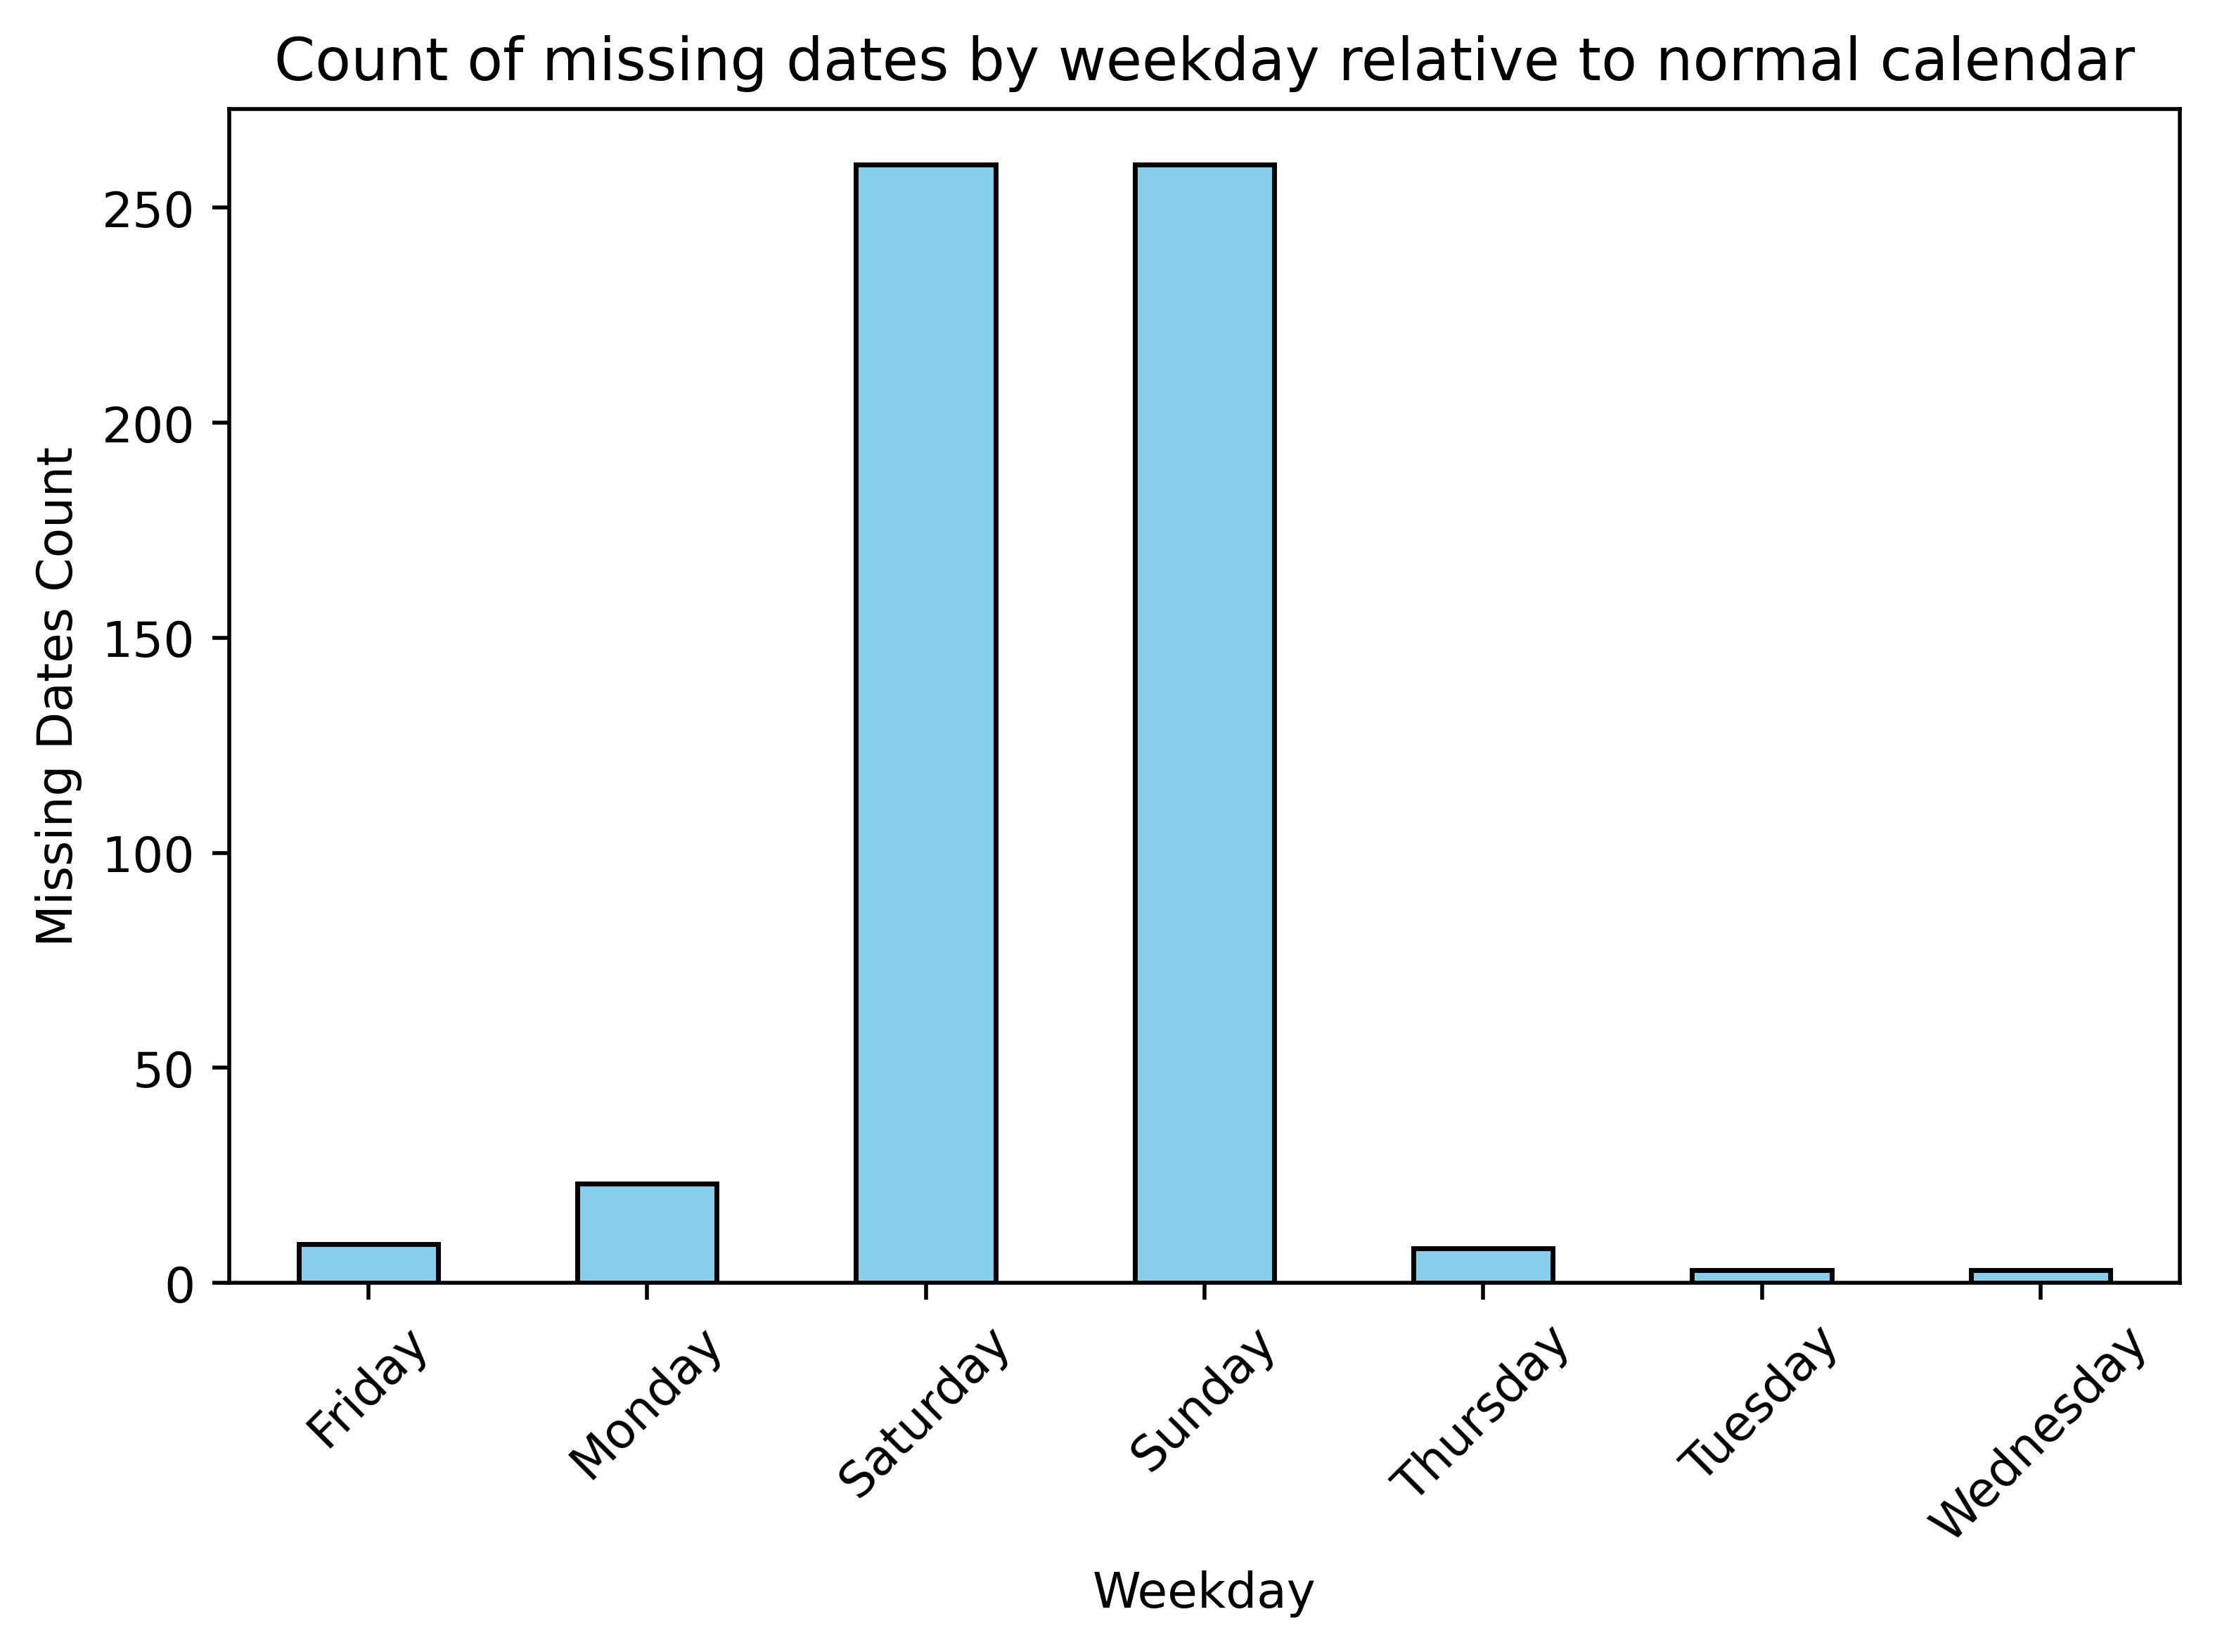

In [5]:
# Count the missing dates
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
missing_dates = full_date_range.difference(df['Date'])
missing_dates_df = pd.DataFrame({'Date': missing_dates})
missing_dates_df['Weekday'] = missing_dates_df['Date'].dt.day_name()

# Count missing dates by weekday
weekday_counts = missing_dates_df['Weekday'].value_counts()

# Plot the counts in a bar chart
weekday_counts.sort_index(inplace=True)  # Sort by weekday order
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of missing dates by weekday relative to normal calendar')
plt.xlabel('Weekday')
plt.ylabel('Missing Dates Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Count the missing dates relative to the financial calendar.
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=df['Date'].min(), end_date=df['Date'].max())

# Generate a list of valid market days
valid_market_days = schedule.index

# Identify missing market days
missing_market_days = valid_market_days.difference(df['Date'])

# Convert to DataFrame for analysis
missing_days_df = pd.DataFrame({'Missing Dates': missing_market_days})
missing_days_df['Weekday'] = missing_days_df['Missing Dates'].dt.day_name()

# Output
print("Missing Market Days:")
print(missing_days_df)

Missing Market Days:
Empty DataFrame
Columns: [Missing Dates, Weekday]
Index: []


### Implication of missing dates
- When comparing the continuity of dates with the normal calendar, some dates are missing. However, it matches with the financial calendar.
- Some dates are missing since the financial market is closed on weekends and public holidays.
- These dates can be backfilled with data from previous dates.
- While predicting, additional checks are essential to account for market holidays.

In [7]:
# Backfill missing dates data.
# Set 'Date' as index
df.set_index('Date', inplace=True)

# Generate the complete date range
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame to include all dates
df = df.reindex(full_date_range)

# Backfill missing rows with the previous day's data
df = df.bfill()

# Reset the index and rename columns
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)


In [8]:
df_test.set_index('Date', inplace=True)

# Generate the complete date range
full_date_range = pd.date_range(start=df_test.index.min(), end=df_test.index.max())

# Reindex the DataFrame to include all dates
df_test = df_test.reindex(full_date_range)

# Backfill missing rows with the previous day's data
df_test = df_test.bfill()

# Reset the index and rename columns
df_test.reset_index(inplace=True)
df_test.rename(columns={'index': 'Date'}, inplace=True)

In [9]:
df.head(n=15)

Date    Open    High     Low   Close      Volume
0  2012-01-03  325.25  332.83  324.97  663.59   7,380,500
1  2012-01-04  331.27  333.87  329.08  666.45   5,749,400
2  2012-01-05  329.83  330.75  326.89  657.21   6,590,300
3  2012-01-06  328.34  328.77  323.68  648.24   5,405,900
4  2012-01-07  322.04  322.29  309.46  620.76  11,688,800
5  2012-01-08  322.04  322.29  309.46  620.76  11,688,800
6  2012-01-09  322.04  322.29  309.46  620.76  11,688,800
7  2012-01-10  313.70  315.72  307.30  621.43   8,824,000
8  2012-01-11  310.59  313.52  309.40  624.25   4,817,800
9  2012-01-12  314.43  315.26  312.08  627.92   3,764,400
10 2012-01-13  311.96  312.30  309.37  623.28   4,631,800
11 2012-01-14  314.81  314.81  311.67  626.86   3,832,800
12 2012-01-15  314.81  314.81  311.67  626.86   3,832,800
13 2012-01-16  314.81  314.81  311.67  626.86   3,832,800
14 2012-01-17  314.81  314.81  311.67  626.86   3,832,800

In [10]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close             object
Volume            object
dtype: object

In [11]:
df_test.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume            object
dtype: object

### Data type inference
- Need to convert Close and Volume columns to float data type for computation.

In [12]:
df['Close'] = df['Close'].apply(lambda x : x.replace(',', '')).astype('float')
df['Volume'] = df['Volume'].apply(lambda x : x.replace(',', '')).astype('float')
df_test['Volume'] = df_test['Volume'].apply(lambda x : x.replace(',', '')).astype('float')

In [13]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [14]:
df_test.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

### Data visualisation

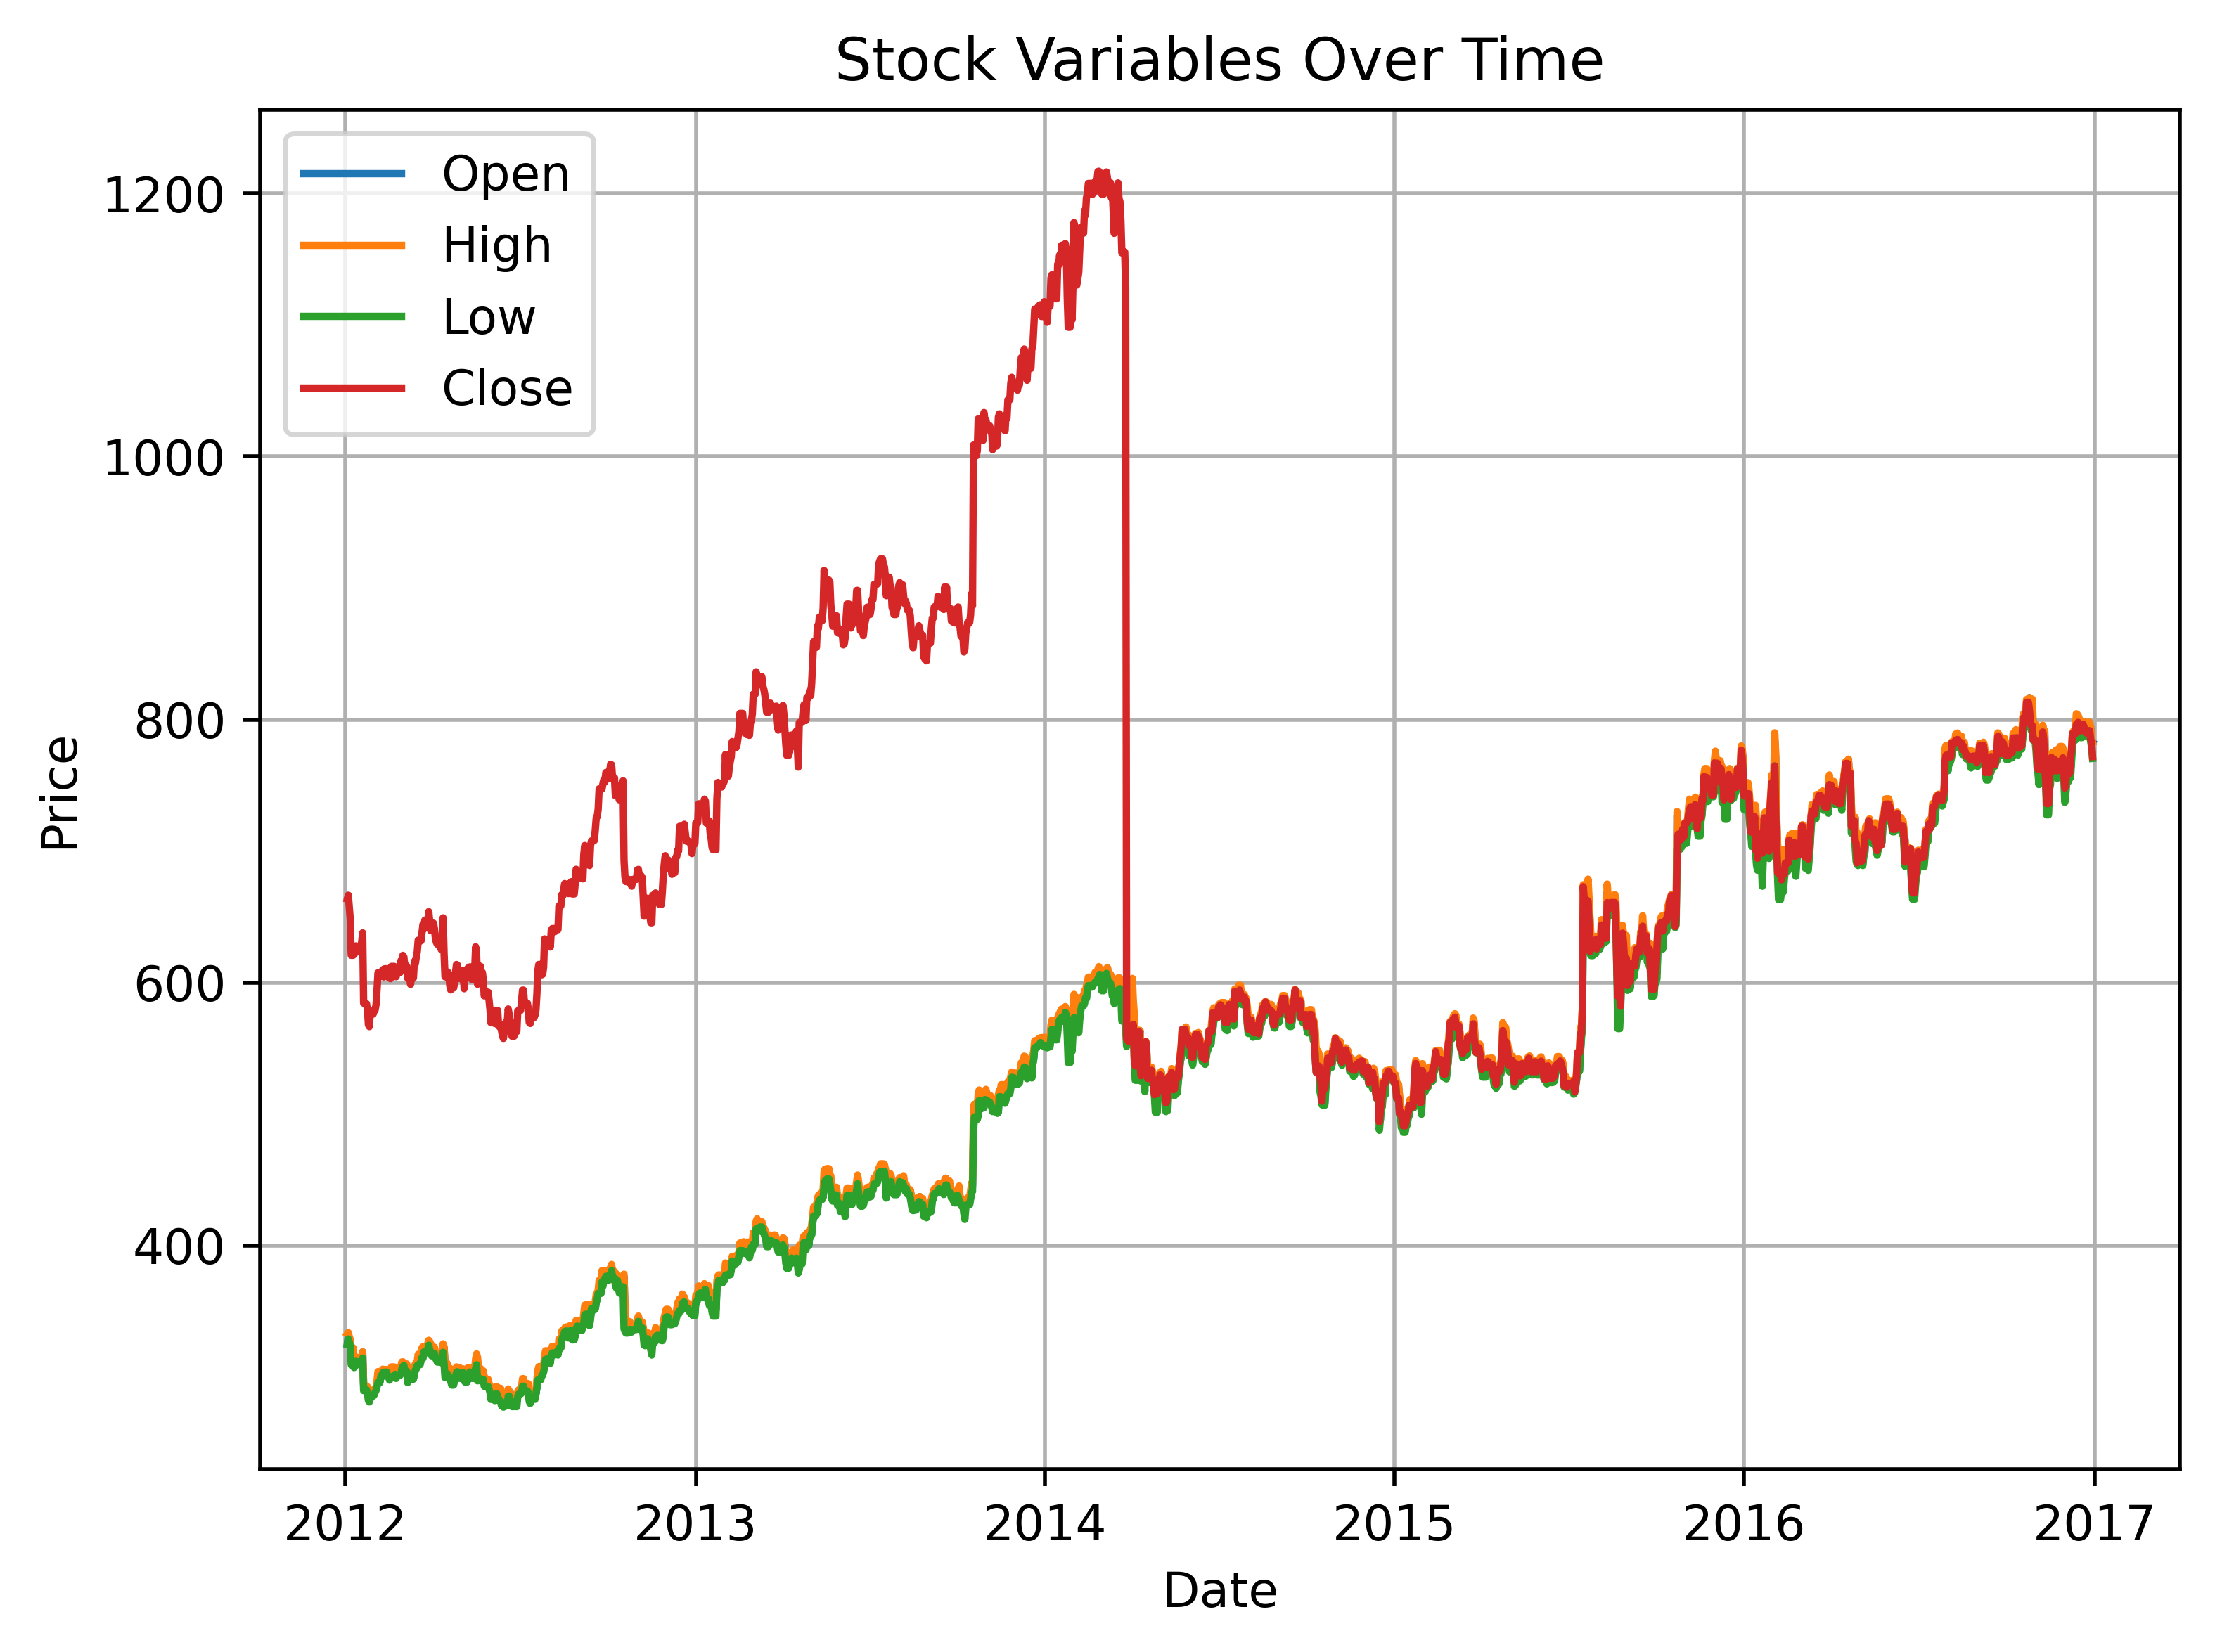

In [15]:
for column in df.drop(['Date', 'Volume'], axis=1).columns:
    plt.plot(df['Date'], df[column], label=column)

# Customize the plot
plt.title('Stock Variables Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()

plt.show()

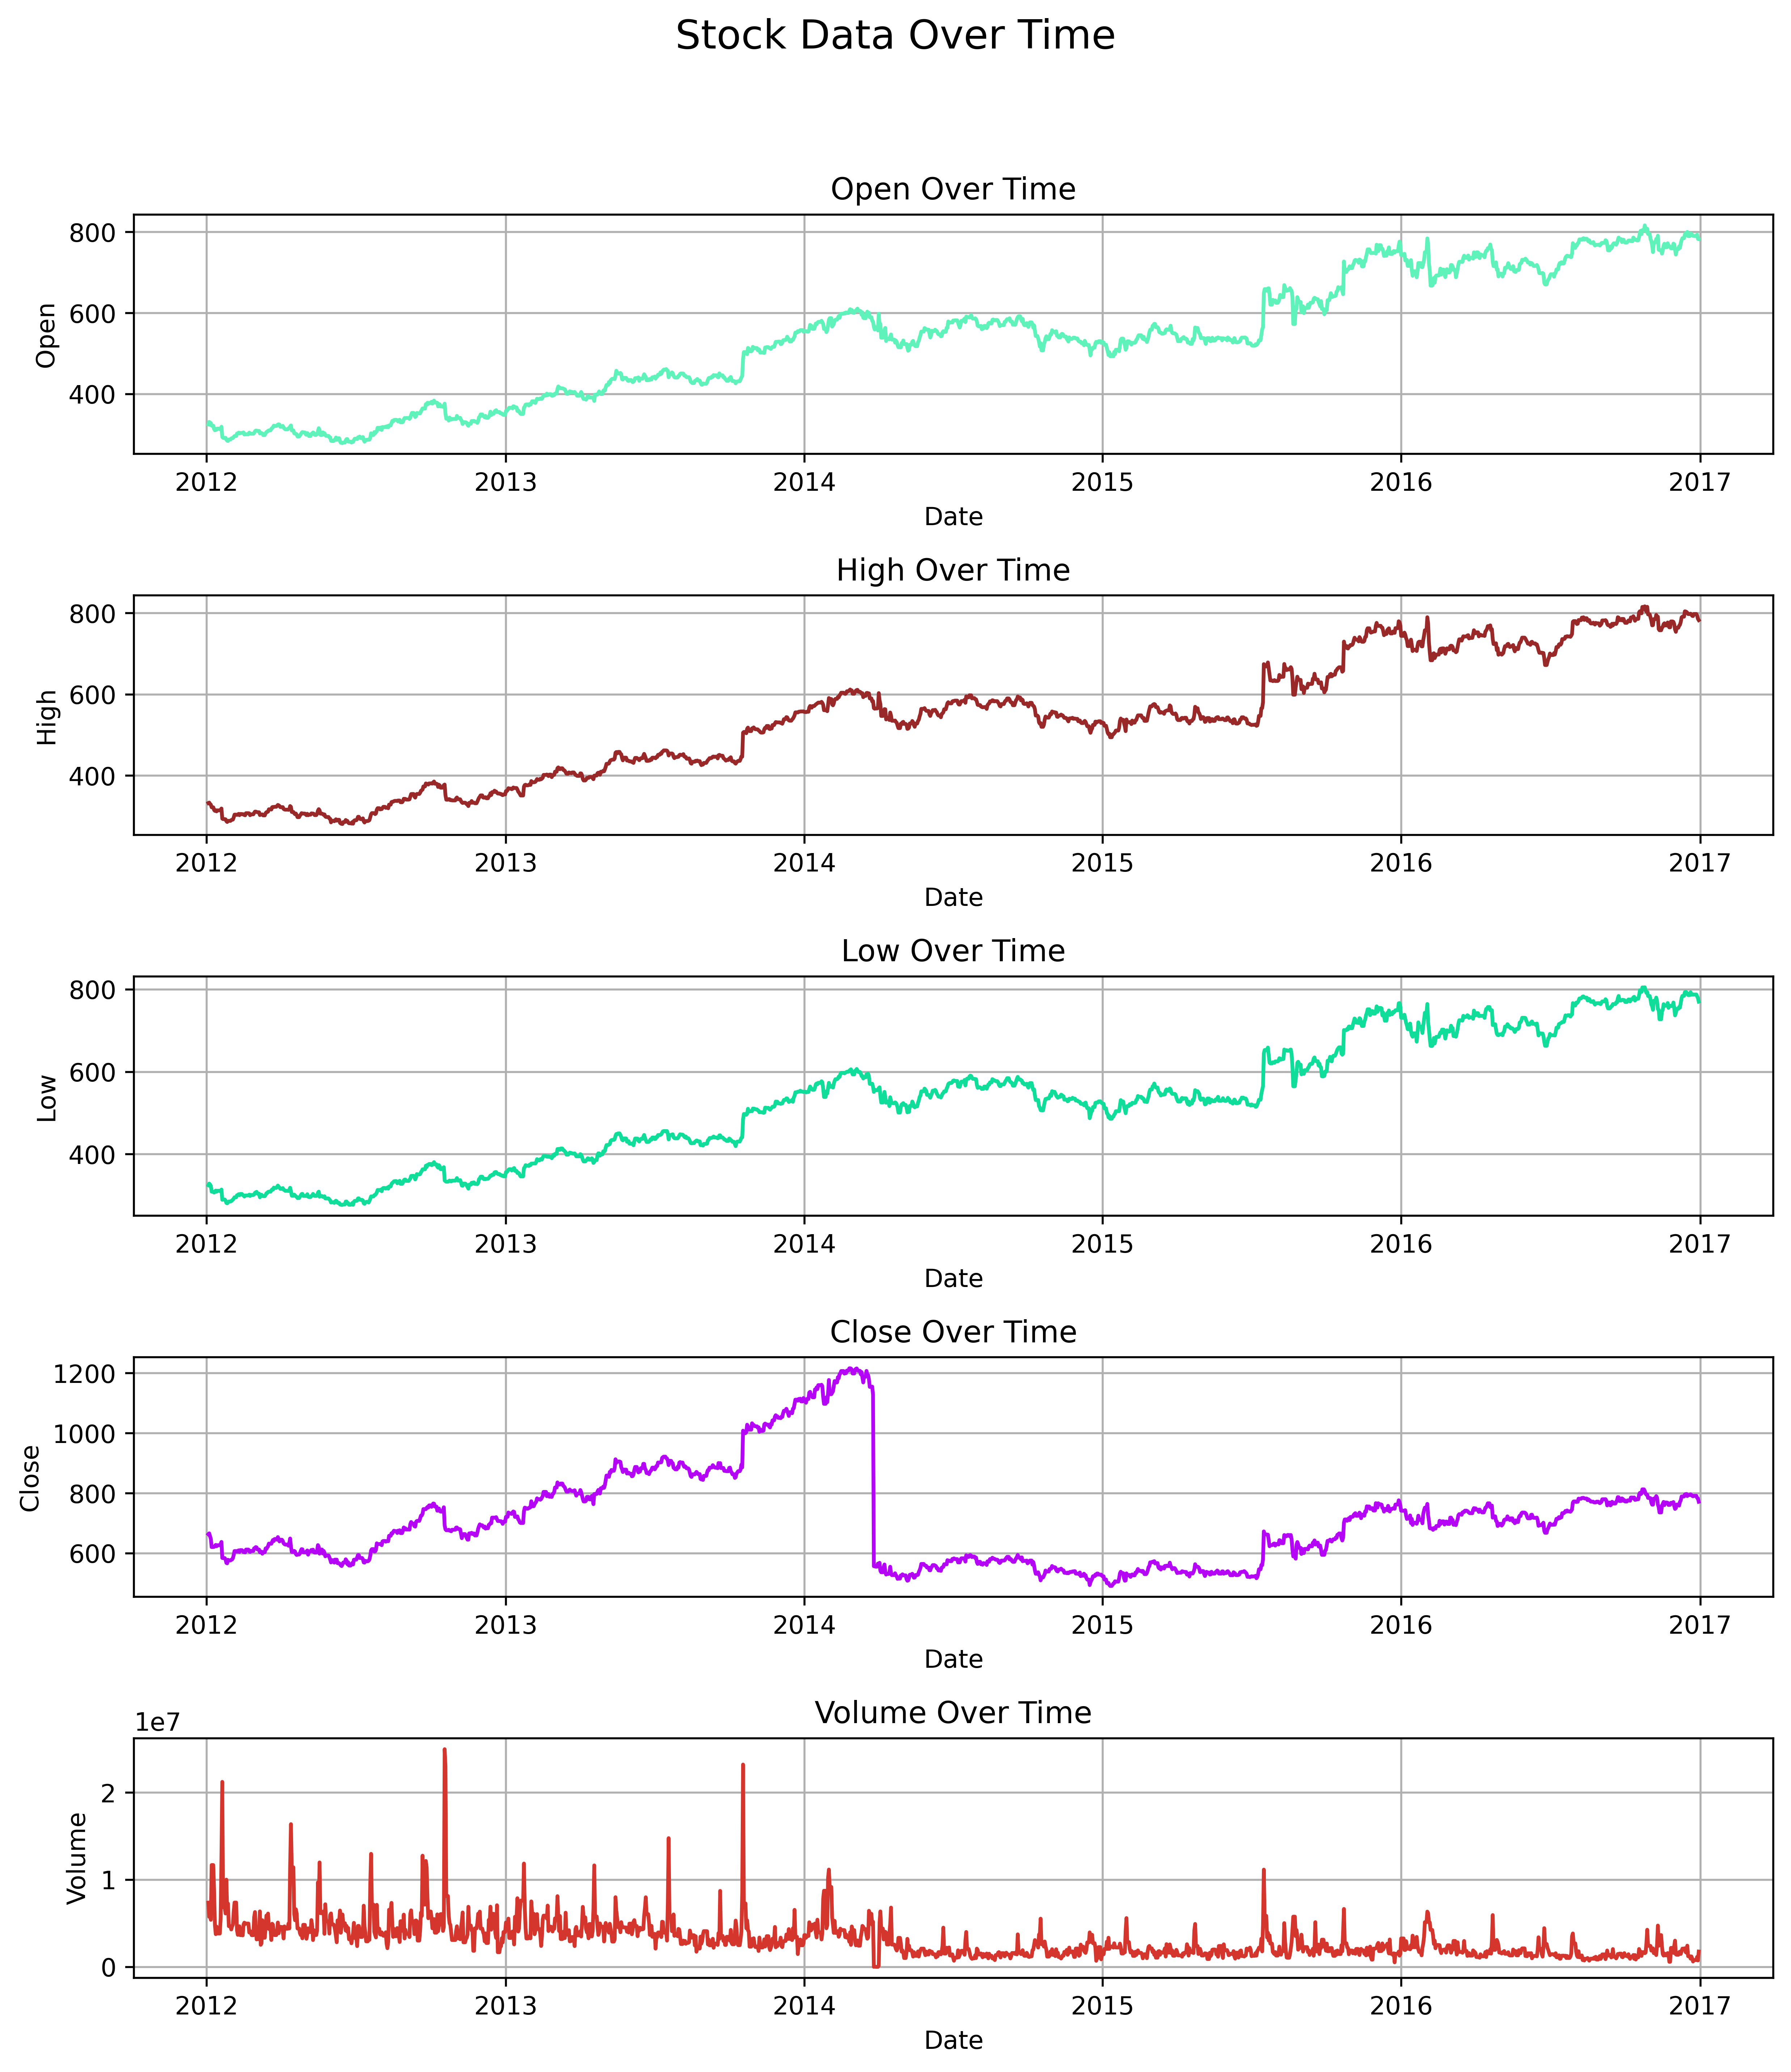

In [16]:
# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 12), sharex=False)

# Plot each variable
variables = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, var in enumerate(variables):
    axes[i].plot(df['Date'], df[var], label=var, color=np.random.rand(3,))
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_ylabel(var)
    axes[i].grid(True)
    axes[i].set_xlabel('Date')

# Set common labels
fig.suptitle('Stock Data Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Open, High, and Low variables have a similar pattern
- The pattern of the Close variable deviates around the year 2014.
- Volume variable has a fluctuating pattern.

### Data distribution

In [17]:
df.describe()

Date         Open         High          Low  \
count                 1824  1824.000000  1824.000000  1824.000000   
mean   2014-07-02 12:00:00   533.072083   537.340543   528.480729   
min    2012-01-03 00:00:00   279.120000   281.210000   277.220000   
25%    2013-04-02 18:00:00   401.150000   406.047500   400.000000   
50%    2014-07-02 12:00:00   537.135000   540.675000   532.400000   
75%    2015-10-01 06:00:00   654.747500   661.380000   644.400000   
max    2016-12-30 00:00:00   816.680000   816.680000   805.140000   
std                    NaN   151.733497   152.865305   150.459229   

             Close        Volume  
count  1824.000000  1.824000e+03  
mean    712.720367  3.106657e+06  
min     491.200000  7.900000e+03  
25%     576.920000  1.600625e+06  
50%     695.160000  2.529300e+06  
75%     781.760000  4.097750e+06  
max    1216.830000  2.497790e+07  
std     165.090467  2.144911e+06

- The data need to be normalised for uniformity across all variables.
- The date variable cannot be used as is. It can be transformed to timestamp.

In [18]:
df['Timestamp'] = df['Date'].astype('int64') // 10**9
df_test['Timestamp'] = df_test['Date'].astype('int64') // 10**9

In [19]:
# Normalize the data
df_close = df[['Close']]
df_test_close = df_test[['Close']]
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_df_close = scaler_close.fit_transform(df_close.values)
scaled_df_test_close = scaler_close.transform(df_test_close.values)

### Convert data to sequence

In [20]:
# Function to create dataset with time steps
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create datasets
X_train, y_train = create_dataset(scaled_df_close)
X_test, y_test = create_dataset(scaled_df_test_close)



In [21]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Modeling

In [22]:
# Model definitions
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


In [23]:
# Train and evaluate model with cross-validation
def train_model(model_class, model_name, params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    train_losses, val_losses = [], []
    best_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nTraining {model_name} - Hidden Size: {params['hidden_size']}, "
              f"Num Layers: {params['num_layers']}, Learning Rate: {params['learning_rate']} - Fold {fold + 1}")

        train_X, val_X = X[train_idx], X[val_idx]
        train_y, val_y = y[train_idx], y[val_idx]

        model = model_class(input_size=1, hidden_size=params['hidden_size'], 
                            num_layers=params['num_layers'], output_size=1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        best_val_loss = float('inf')
        early_stop_count = 0
        fold_train_loss, fold_val_loss = [], []

        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            output = model(train_X)
            loss = criterion(output, train_y.view(-1, 1))
            loss.backward()
            optimizer.step()
            fold_train_loss.append(loss.item())

            model.eval()
            with torch.no_grad():
                val_output = model(val_X)
                val_loss = criterion(val_output, val_y.view(-1, 1)).item()
                fold_val_loss.append(val_loss)

            # Print training progress
            print(f"    Epoch {epoch+1}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping and saving best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the best model weights
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count > 10:
                print(f"    Early stopping at epoch {epoch+1}")
                break

        train_losses.append(fold_train_loss)
        val_losses.append(fold_val_loss)
        val_rmse = np.sqrt(best_val_loss)
        results.append({'Fold': fold + 1, 'Val_RMSE': val_rmse})
        best_models.append(best_model_state)

    return results, train_losses, val_losses, best_models


In [24]:
# Hyperparameter grid
hidden_sizes = [16, 32, 64]
num_layers_list = [1, 2, 3]
learning_rates = [0.01, 0.001, 0.0001]

# Store results
final_results = []

for model_class, model_name in zip([RNNModel, LSTMModel, GRUModel], ['RNN', 'LSTM', 'GRU']):
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            for lr in learning_rates:
                params = {'hidden_size': hidden_size, 'num_layers': num_layers, 'learning_rate': lr}
                results, train_losses, val_losses, best_models = train_model(model_class, model_name, params, X_train, y_train)
                avg_rmse = np.mean([r['Val_RMSE'] for r in results])
                final_results.append({
                    'Model': model_name,
                    'Hidden_Size': hidden_size,
                    'Num_Layers': num_layers,
                    'Learning_Rate': lr,
                    'Avg_Val_RMSE': avg_rmse,
                    'Best_Models': best_models,
                    'Train_Loss': train_losses,
                    'Val_Loss': val_losses
                })

# Store results in a DataFrame
results_df = pd.DataFrame(final_results)


Training RNN - Hidden Size: 16, Num Layers: 1, Learning Rate: 0.01 - Fold 1
    Epoch 1: Train Loss: 0.2790, Val Loss: 0.1687
    Epoch 2: Train Loss: 0.1694, Val Loss: 0.0910
    Epoch 3: Train Loss: 0.0926, Val Loss: 0.0459
    Epoch 4: Train Loss: 0.0484, Val Loss: 0.0346
    Epoch 5: Train Loss: 0.0379, Val Loss: 0.0499
    Epoch 6: Train Loss: 0.0537, Val Loss: 0.0617
    Epoch 7: Train Loss: 0.0657, Val Loss: 0.0555
    Epoch 8: Train Loss: 0.0592, Val Loss: 0.0410
    Epoch 9: Train Loss: 0.0444, Val Loss: 0.0296
    Epoch 10: Train Loss: 0.0326, Val Loss: 0.0256
    Epoch 11: Train Loss: 0.0281, Val Loss: 0.0280
    Epoch 12: Train Loss: 0.0300, Val Loss: 0.0324
    Epoch 13: Train Loss: 0.0341, Val Loss: 0.0344
    Epoch 14: Train Loss: 0.0359, Val Loss: 0.0321
    Epoch 15: Train Loss: 0.0335, Val Loss: 0.0267
    Epoch 16: Train Loss: 0.0281, Val Loss: 0.0206
    Epoch 17: Train Loss: 0.0221, Val Loss: 0.0163
    Epoch 18: Train Loss: 0.0179, Val Loss: 0.0147
    Epoch 19: 

In [25]:
results_df

Model  Hidden_Size  Num_Layers  Learning_Rate  Avg_Val_RMSE  \
0    RNN           16           1         0.0100      0.031944   
1    RNN           16           1         0.0010      0.131322   
2    RNN           16           1         0.0001      0.294615   
3    RNN           16           2         0.0100      0.030626   
4    RNN           16           2         0.0010      0.043201   
..   ...          ...         ...            ...           ...   
76   GRU           64           2         0.0010      0.033812   
77   GRU           64           2         0.0001      0.200117   
78   GRU           64           3         0.0100      0.039841   
79   GRU           64           3         0.0010      0.038830   
80   GRU           64           3         0.0001      0.184926   

                                          Best_Models  \
0   [{'rnn.weight_ih_l0': [tensor([0.1667]), tenso...   
1   [{'rnn.weight_ih_l0': [tensor([0.1569]), tenso...   
2   [{'rnn.weight_ih_l0': [tensor([0.1989]), tenso...   
3   [{'rnn.weight_ih_l0': [tensor([0.1576]), tenso...   
4   [{'rnn.weight_ih_l0': [tensor([-0.3123]), tens...   
..                                                ...   
76  [{'gru.weight_ih_l0': [tensor([-0.0703]), tens...   
77  [{'gru.weight_ih_l0': [tensor([-0.0344]), tens...   
78  [{'gru.weight_ih_l0': [tensor([-0.0830]), tens...   
79  [{'gru.weight_ih_l0': [tensor([0.0973]), tenso...   
80  [{'gru.weight_ih_l0': [tensor([-0.0137]), tens...   

                                           Train_Loss  \
0   [[0.27901747822761536, 0.16941970586776733, 0....   
1   [[0.3341616094112396, 0.3165857791900635, 0.29...   
2   [[0.25143736600875854, 0.2501688003540039, 0.2...   
3   [[0.24241703748703003, 0.0809473842382431, 0.0...   
4   [[0.16666170954704285, 0.1512746512889862, 0.1...   
..                                                ...   
76  [[0.10376840084791183, 0.08133231848478317, 0....   
77  [[0.11637803912162781, 0.11356403678655624, 0....   
78  [[0.16701377928256989, 0.12225812673568726, 0....   
79  [[0.13676904141902924, 0.1006350889801979, 0.0...   
80  [[0.22771400213241577, 0.22108201682567596, 0....   

                                             Val_Loss  
0   [[0.16871659457683563, 0.09098560363054276, 0....  
1   [[0.3169458210468292, 0.3000011742115021, 0.28...  
2   [[0.25039368867874146, 0.2491171956062317, 0.2...  
3   [[0.0786404237151146, 0.04628143087029457, 0.0...  
4   [[0.14965254068374634, 0.13522891700267792, 0....  
..                                                ...  
76  [[0.07844875007867813, 0.06192464753985405, 0....  
77  [[0.11140142381191254, 0.10860975831747055, 0....  
78  [[0.11598192155361176, 0.06522061675786972, 0....  
79  [[0.09848075360059738, 0.07251737266778946, 0....  
80  [[0.22054177522659302, 0.2139989286661148, 0.2...  

[81 rows x 8 columns]

## Testing

- Perform testing on Test data.

/Users/abinshoby/miniforge3/envs/tf_new/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/abinshoby/miniforge3/envs/tf_new/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/abinshoby/miniforge3/envs/tf_new/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([29])). This will likely lead to incorrect results

Test RMSE for RNN: 0.0221
Test RMSE for LSTM: 0.0207
Test RMSE for GRU: 0.0214


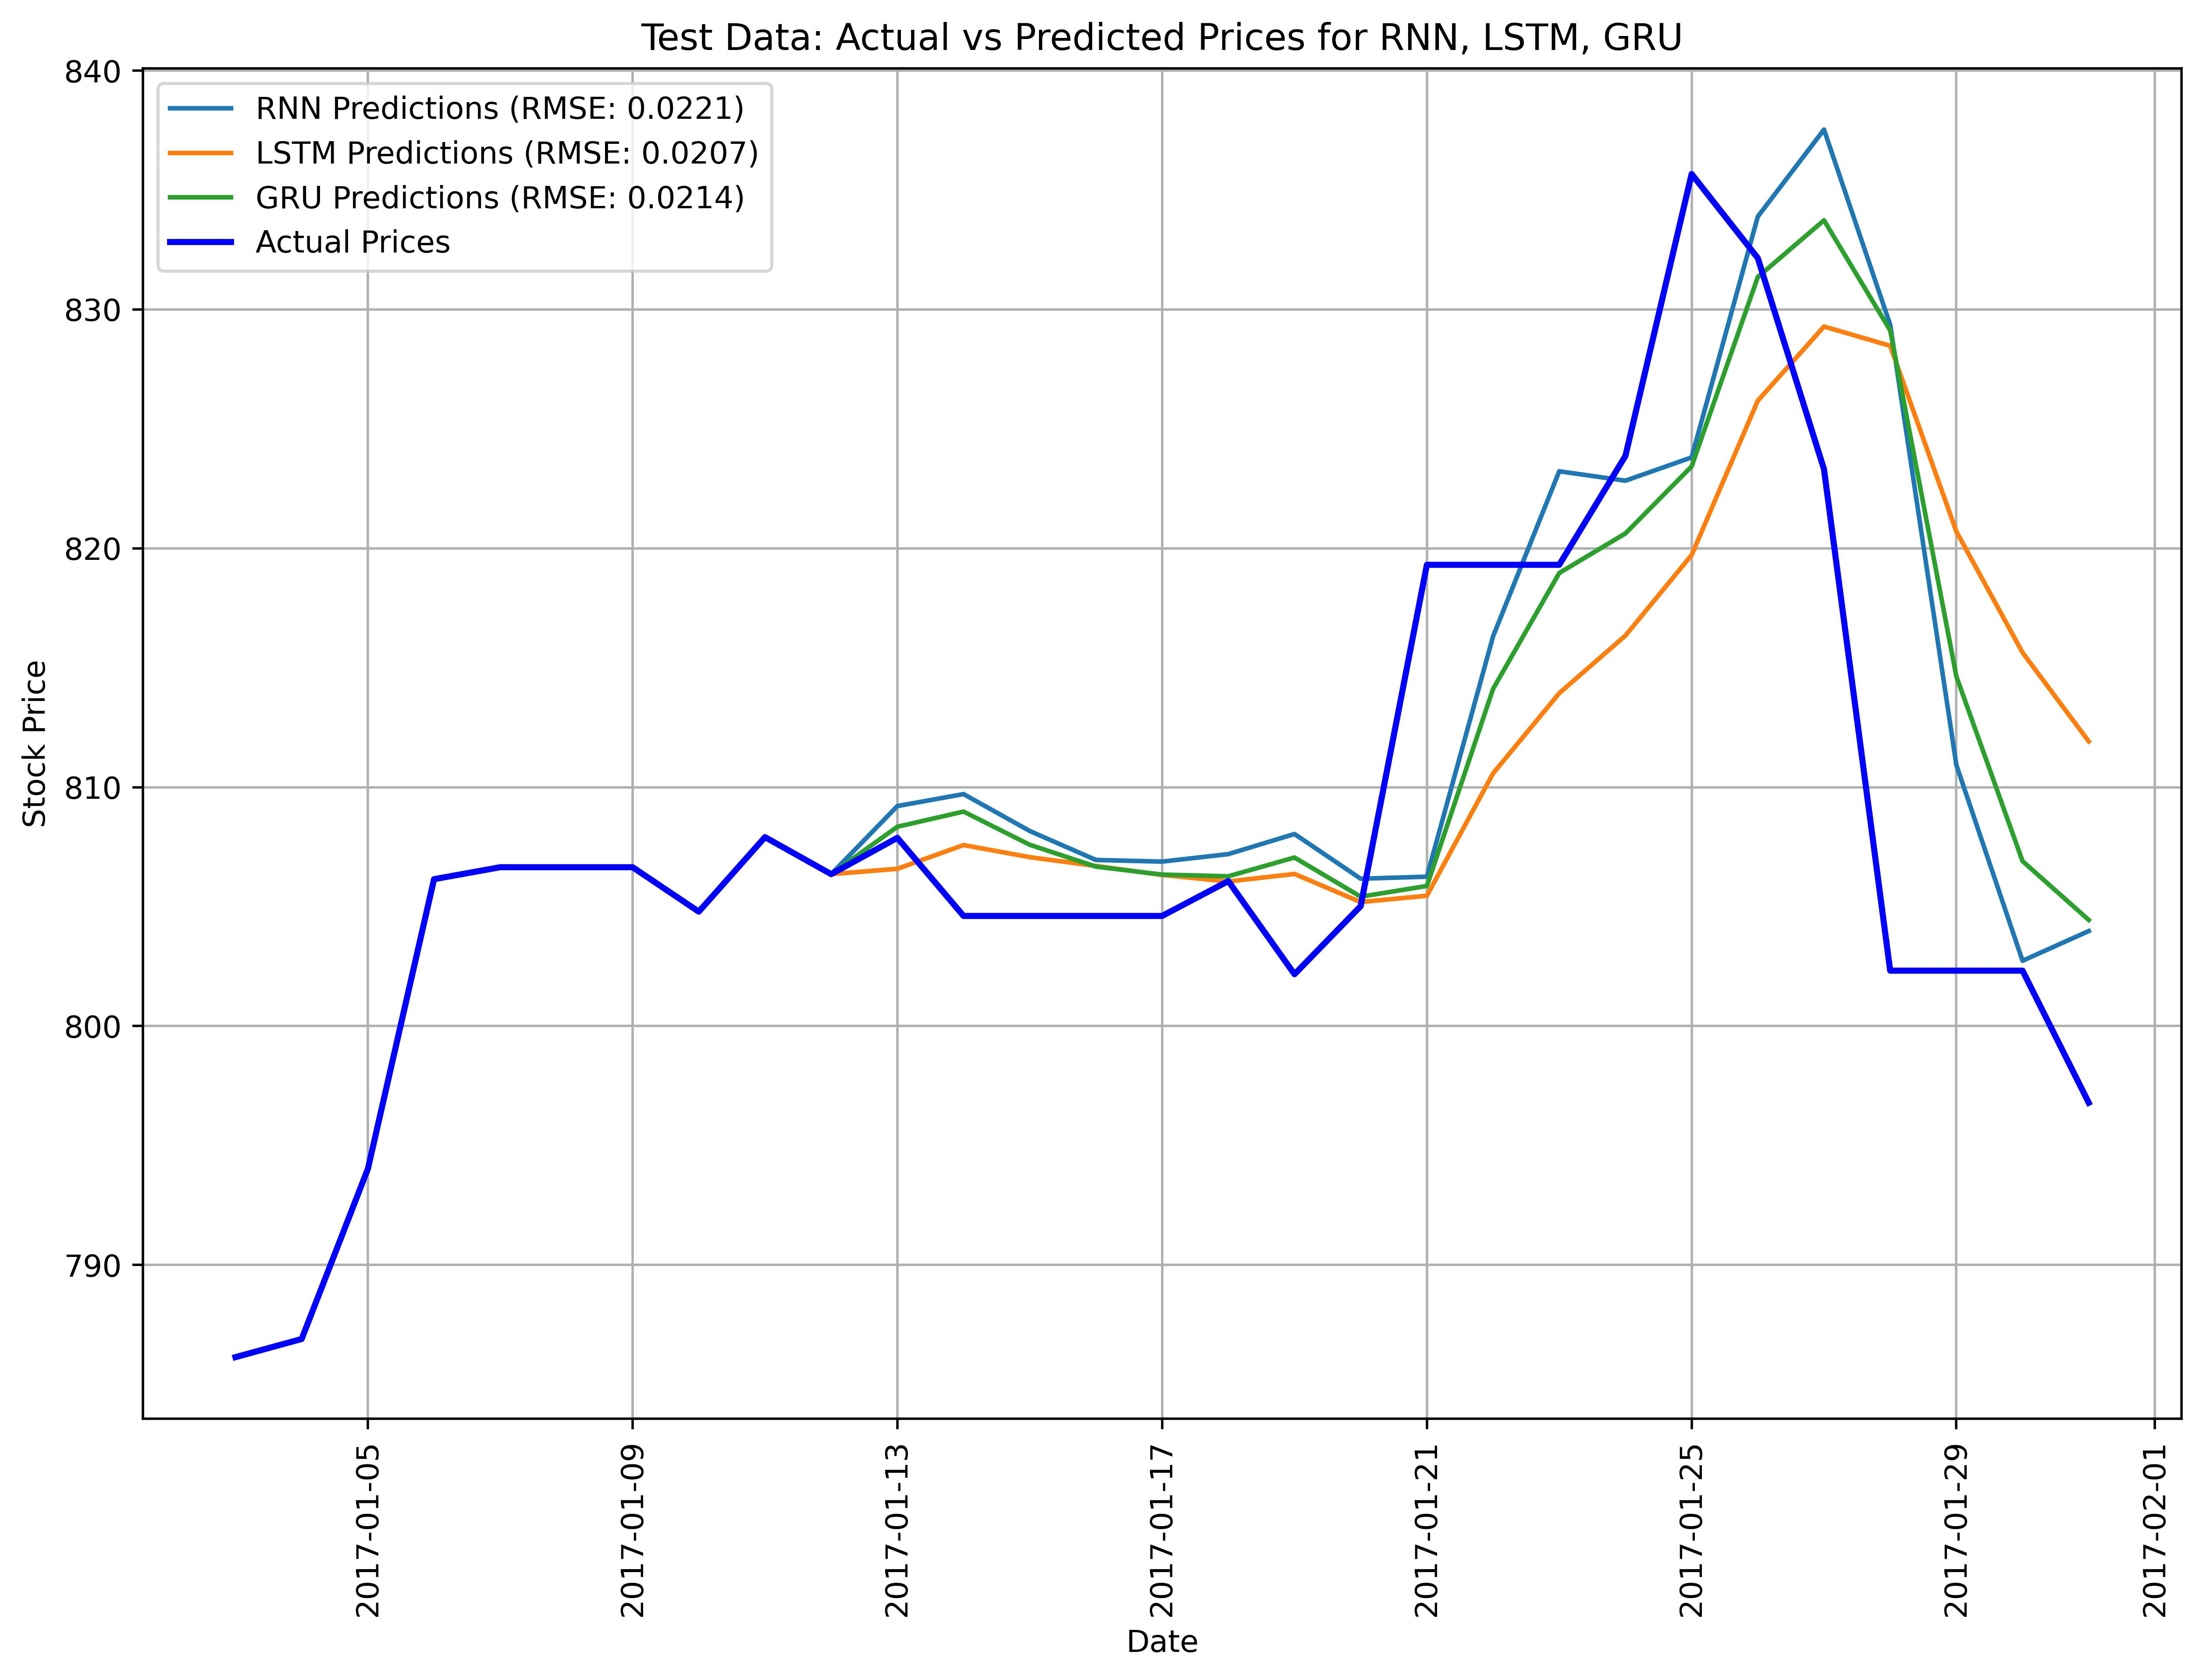

In [26]:
# Test each model and plot predictions
plt.figure(figsize=(12, 8))
intial_outs = X_test[0].reshape((1, *X_test[0].shape)).clone()
y_actual = torch.cat((intial_outs.flatten(), y_test.flatten()))
actual_prices = scaler_close.inverse_transform(y_actual.numpy().reshape(-1, 1)).flatten()
final_results = []
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    # Filter the best parameters for this model
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    best_params = {
        'hidden_size': best_row['Hidden_Size'],
        'num_layers': best_row['Num_Layers'],
        'learning_rate': best_row['Learning_Rate']
    }
    best_weights = best_row['Best_Models'][0]  # Load the best model weights for the first fold
    
    # Initialize and load the model
    best_model = model_class(input_size=1, hidden_size=int(best_params['hidden_size']),
                             num_layers=int(best_params['num_layers']), output_size=1)
    best_model.load_state_dict(best_weights)
    
    # Evaluate on the test set
    best_model.eval()
    with torch.no_grad():
        test_output = best_model(X_test)
        test_output = torch.cat((intial_outs.flatten(), test_output.flatten()))
        predicted_prices = scaler_close.inverse_transform([test_output.numpy()]).flatten()
        
        
    
    # Calculate RMSE for test set
    criterion = nn.MSELoss()
    test_rmse = np.sqrt(criterion(test_output, y_test.view(-1, 1)).item())
    print(f"Test RMSE for {model_name}: {test_rmse:.4f}")
    
    # Plot the predictions
    plt.plot(df_test['Date'], predicted_prices, label=f'{model_name} Predictions (RMSE: {test_rmse:.4f})')
    final_results.append({
        'Model': model_name,
        'Hidden size': best_row['Hidden_Size'],
        '#Layers': best_row['Num_Layers'],
        'Learning rate': best_row['Learning_Rate'],
        'Avg Val RMSE': best_row['Avg_Val_RMSE'],
        'Test RMSE': test_rmse
    })

# Plot actual prices
plt.plot(df_test['Date'], actual_prices, label='Actual Prices', color='blue', linewidth=2)
plt.xticks(rotation=90)
# Customize the plot
plt.title('Test Data: Actual vs Predicted Prices for RNN, LSTM, GRU')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


## Evaluation

In [27]:
fr = pd.DataFrame(final_results)
fr

Model  Hidden size  #Layers  Learning rate  Avg Val RMSE  Test RMSE
0   RNN           32        1           0.01      0.021602   0.022136
1  LSTM           16        1           0.01      0.029571   0.020660
2   GRU           64        1           0.01      0.023685   0.021448

In [28]:
def square_matrix(matrix):
    """
    Convert sparse matrix to dense matrix.
    """
    max_length = max(len(row) for row in matrix)
    
    # Pad each row by duplicating the last element until it matches max_length
    for row in matrix:
        row.extend([row[-1]] * (max_length - len(row)))
    
    return matrix

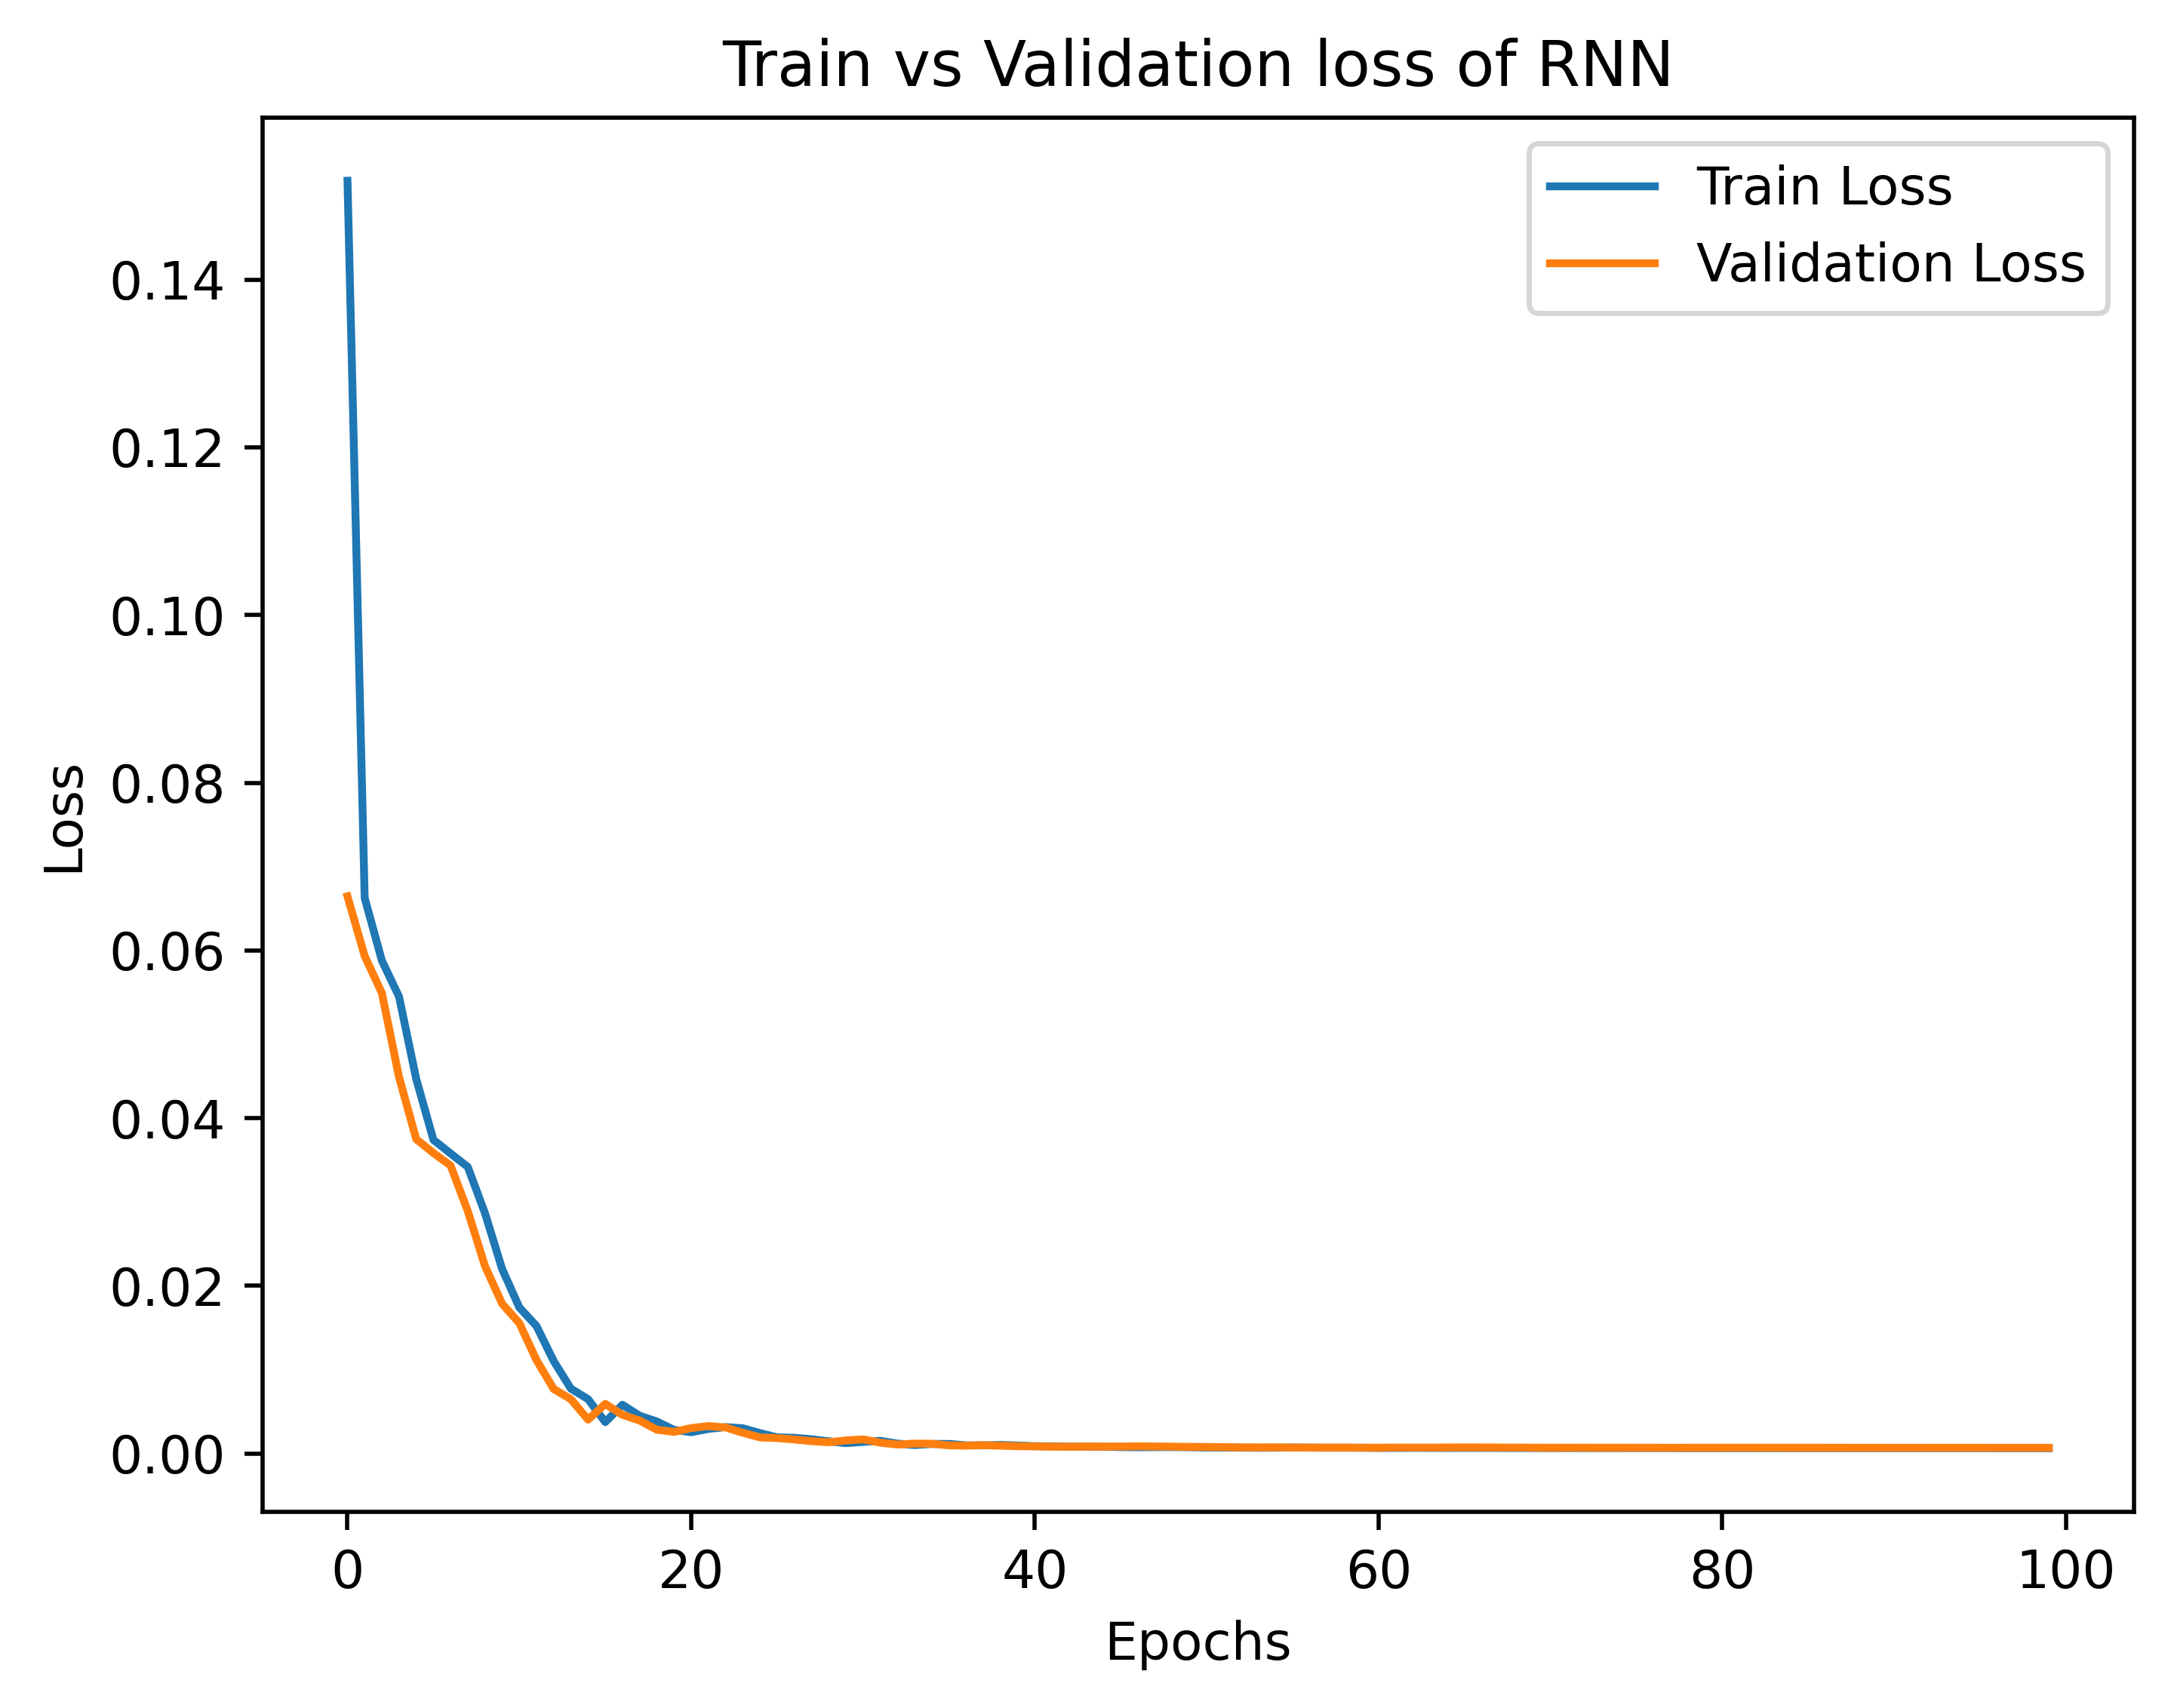

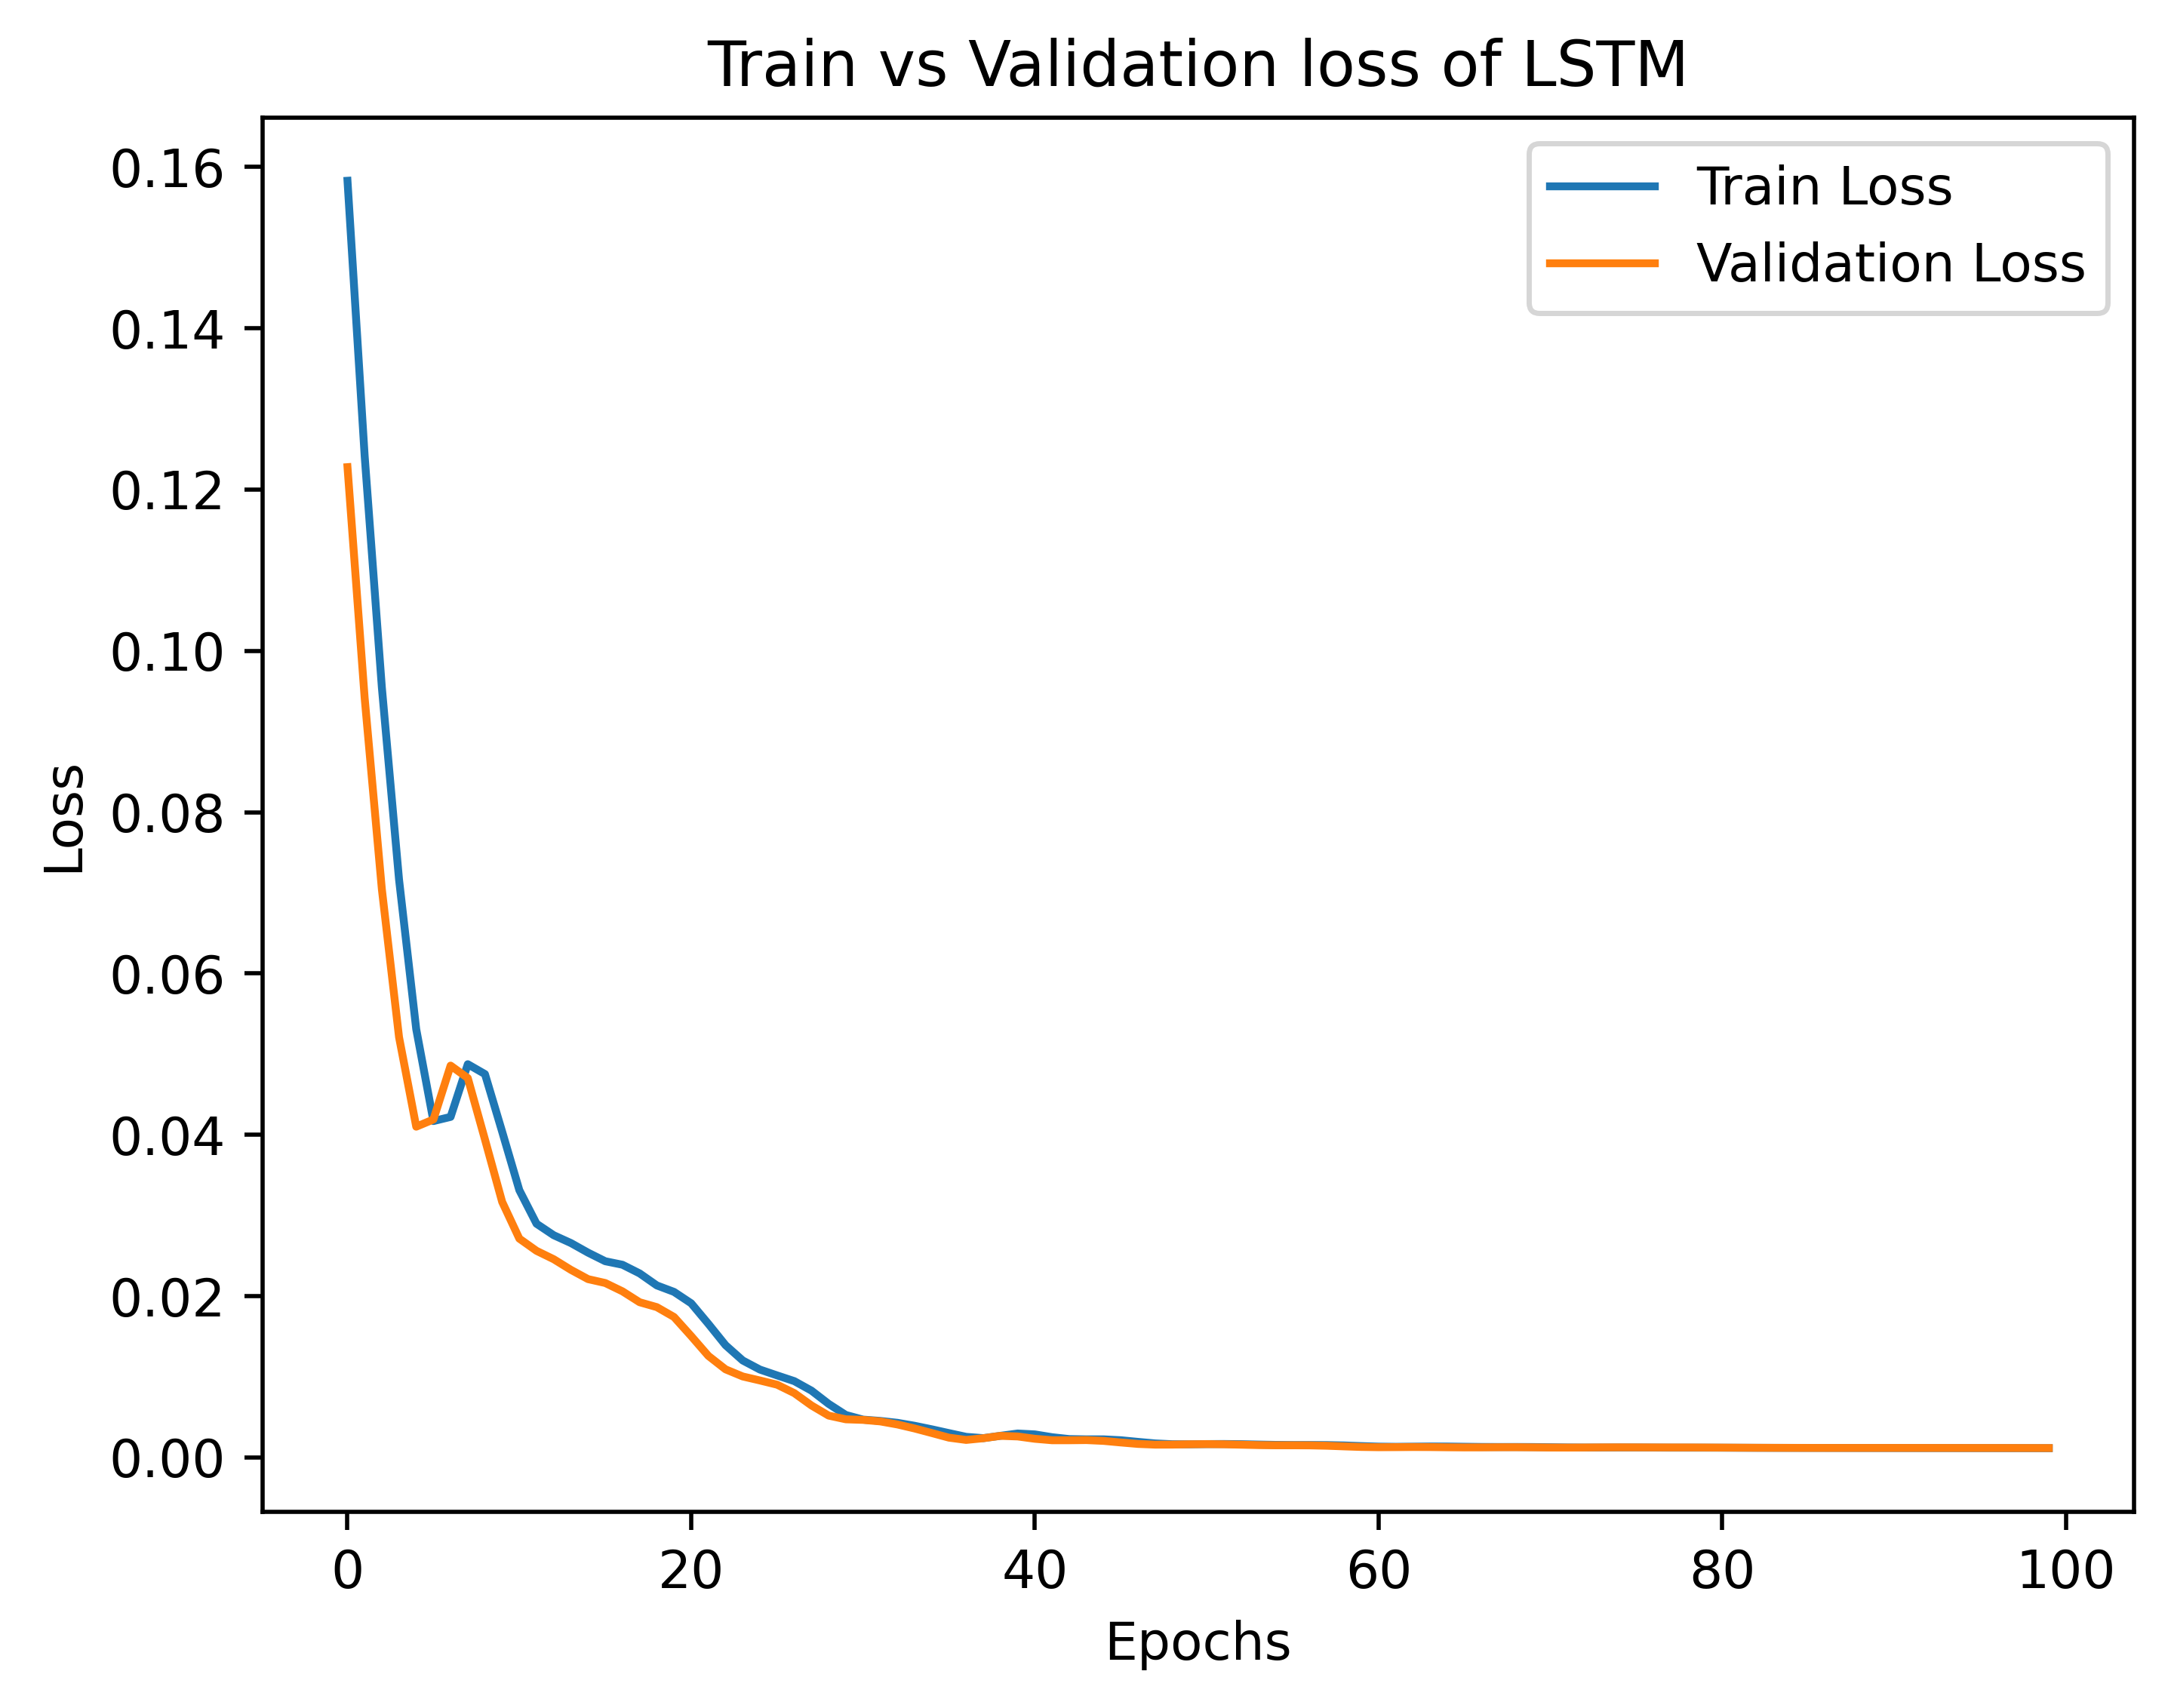

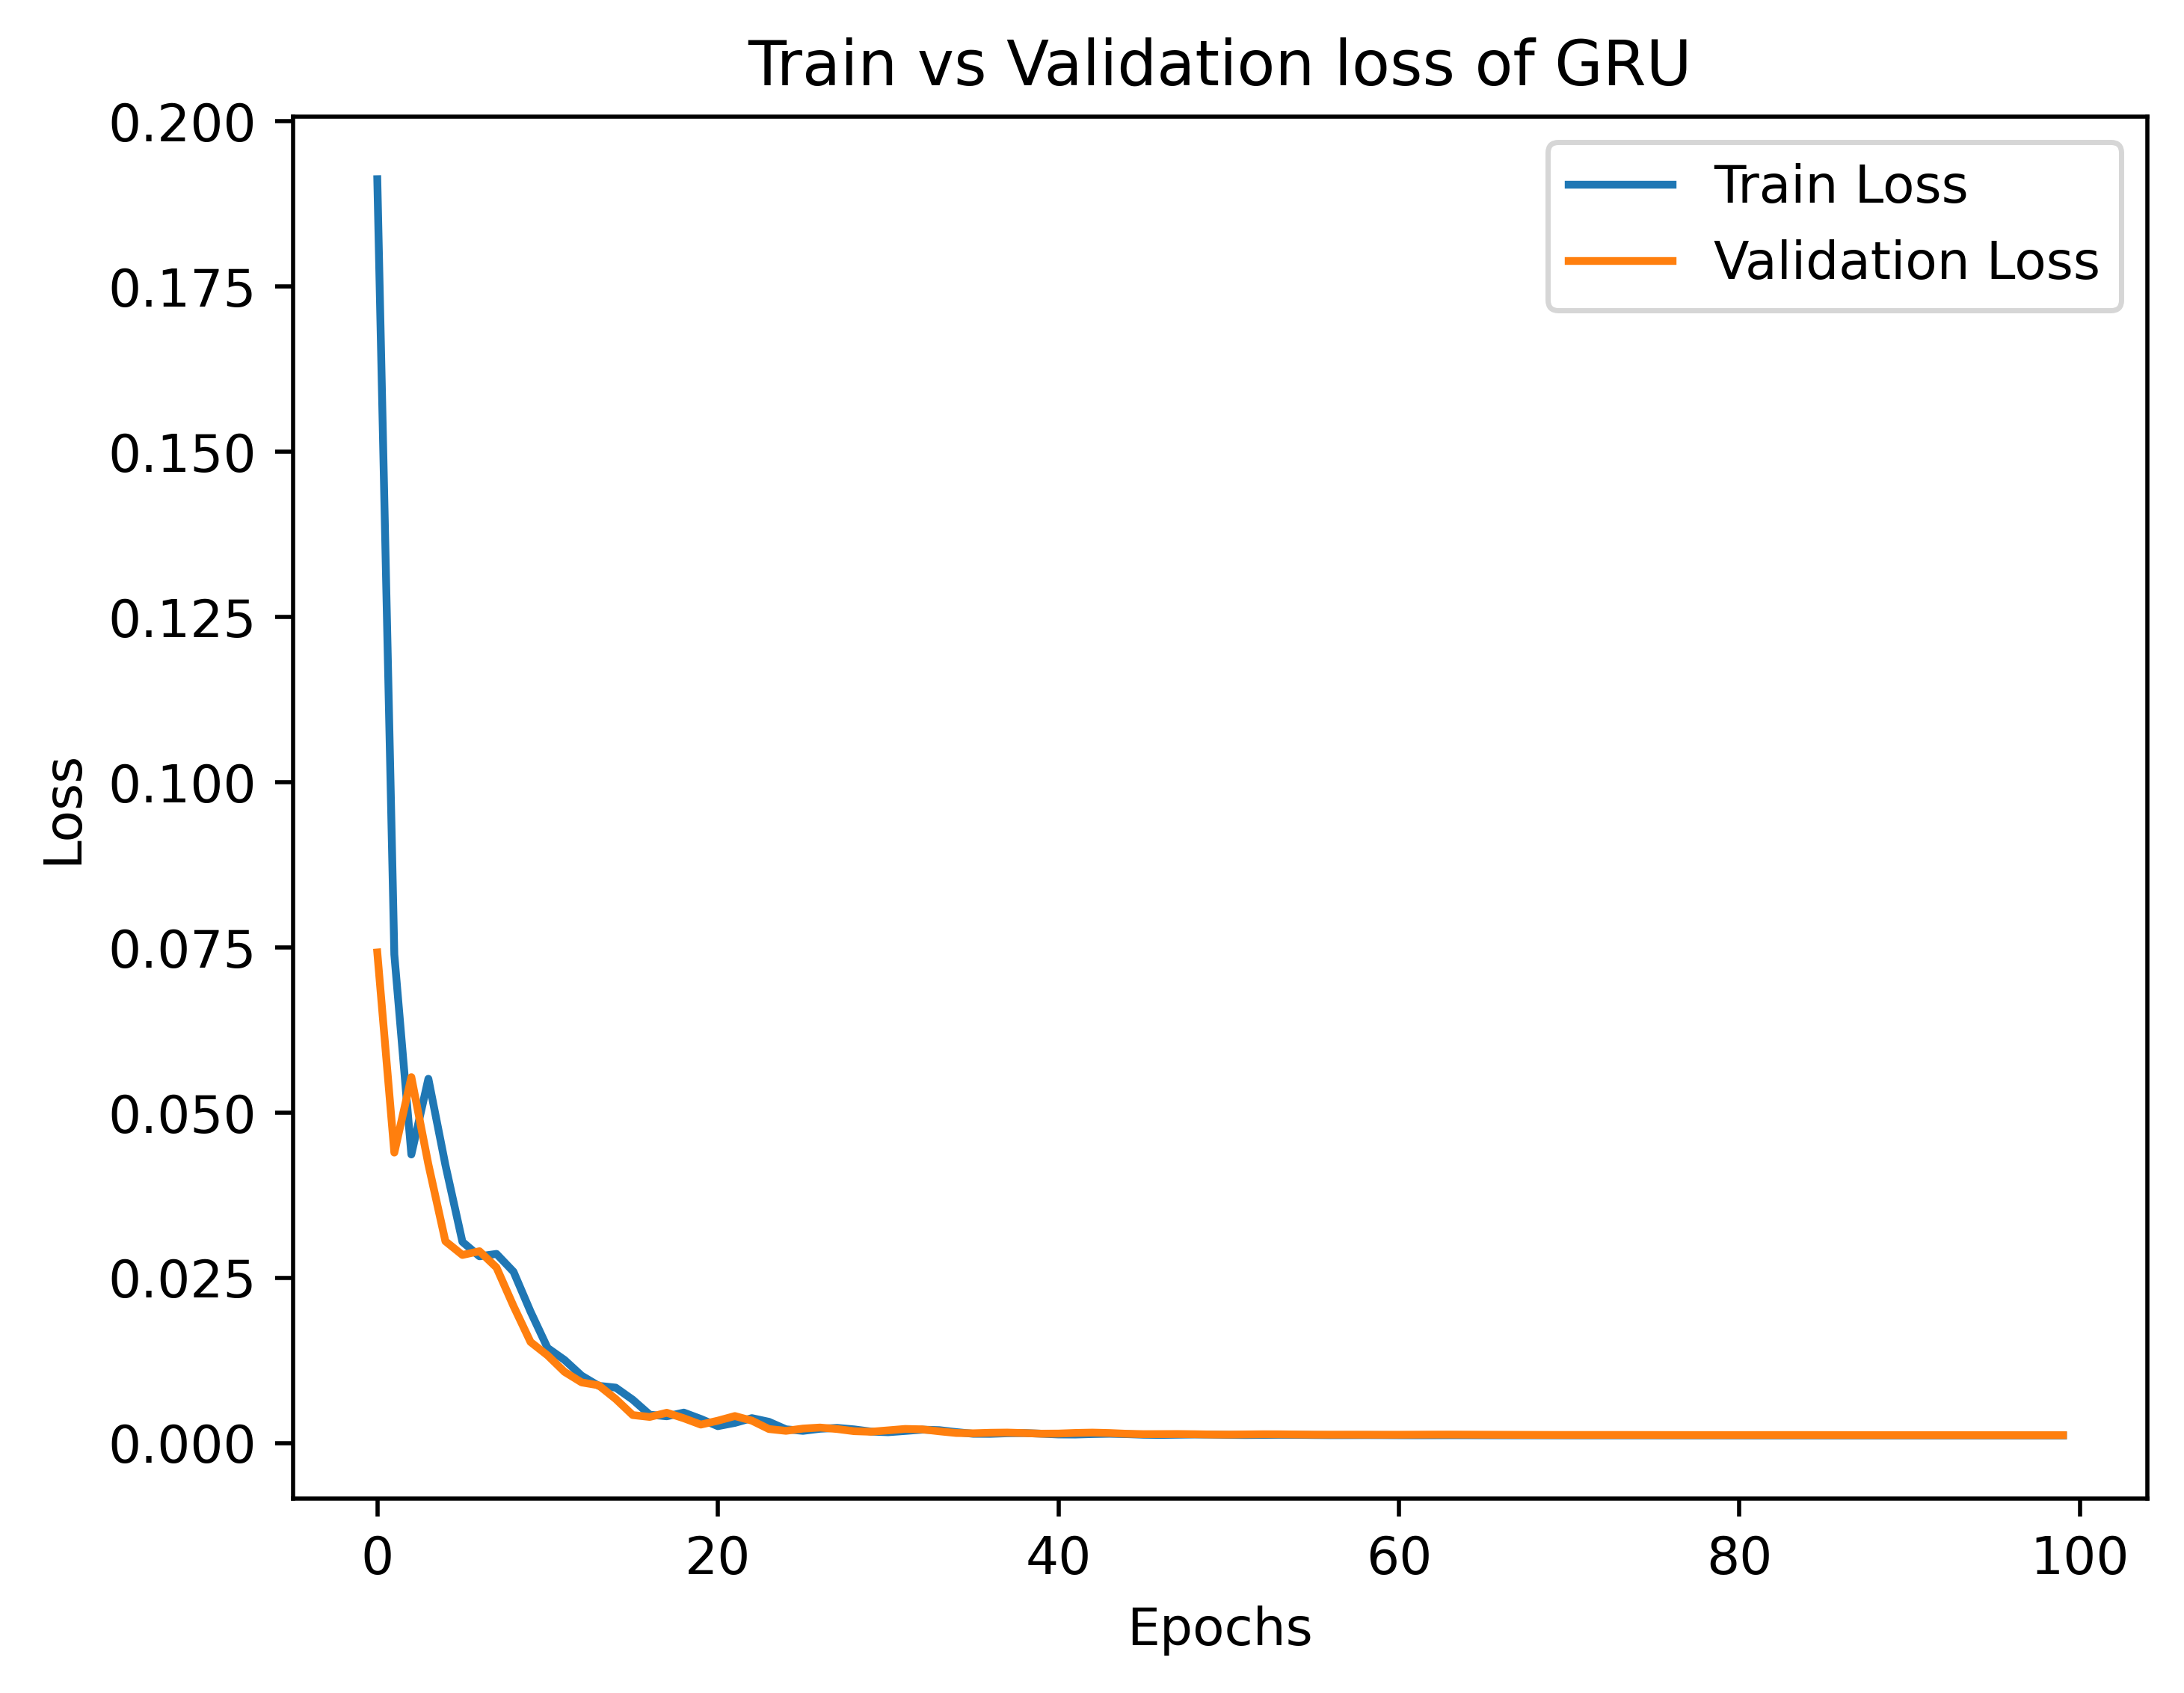

In [29]:
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    train_loss = square_matrix(best_row['Train_Loss'])
    val_loss = square_matrix(best_row['Val_Loss'])
    train_loss = np.mean(train_loss, axis=0)
    val_loss = np.mean(val_loss, axis=0)
    epochs = range(train_loss.shape[0])
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train vs Validation loss of {model_name}")
    plt.show()

### Autoregression

- Generate output one by one

In [30]:
def auto_regression(model, data, y):
    """
    Function for autoregressive output
    """
    initial_sequence = data[0].reshape((1, *data[0].shape)).clone()
    auto_out = initial_sequence.clone()
    actual_out = initial_sequence.clone()
    current_sequence = initial_sequence.clone()
    for i in range(len(y)):
        out = model(current_sequence)
        out = torch.tensor([[[out]]])
        auto_out = torch.cat((auto_out, out), dim=1)
        current_sequence = torch.cat((current_sequence[:, 1:, :], out), dim=1)
        actual_out = torch.cat((actual_out, torch.tensor([[[y[i]]]])), dim=1)
    # Return predicted and actual outputs
    return auto_out[0], actual_out[0]
    

Test RMSE for RNN: 0.0228
Test RMSE for LSTM: 0.0124
Test RMSE for GRU: 0.0145


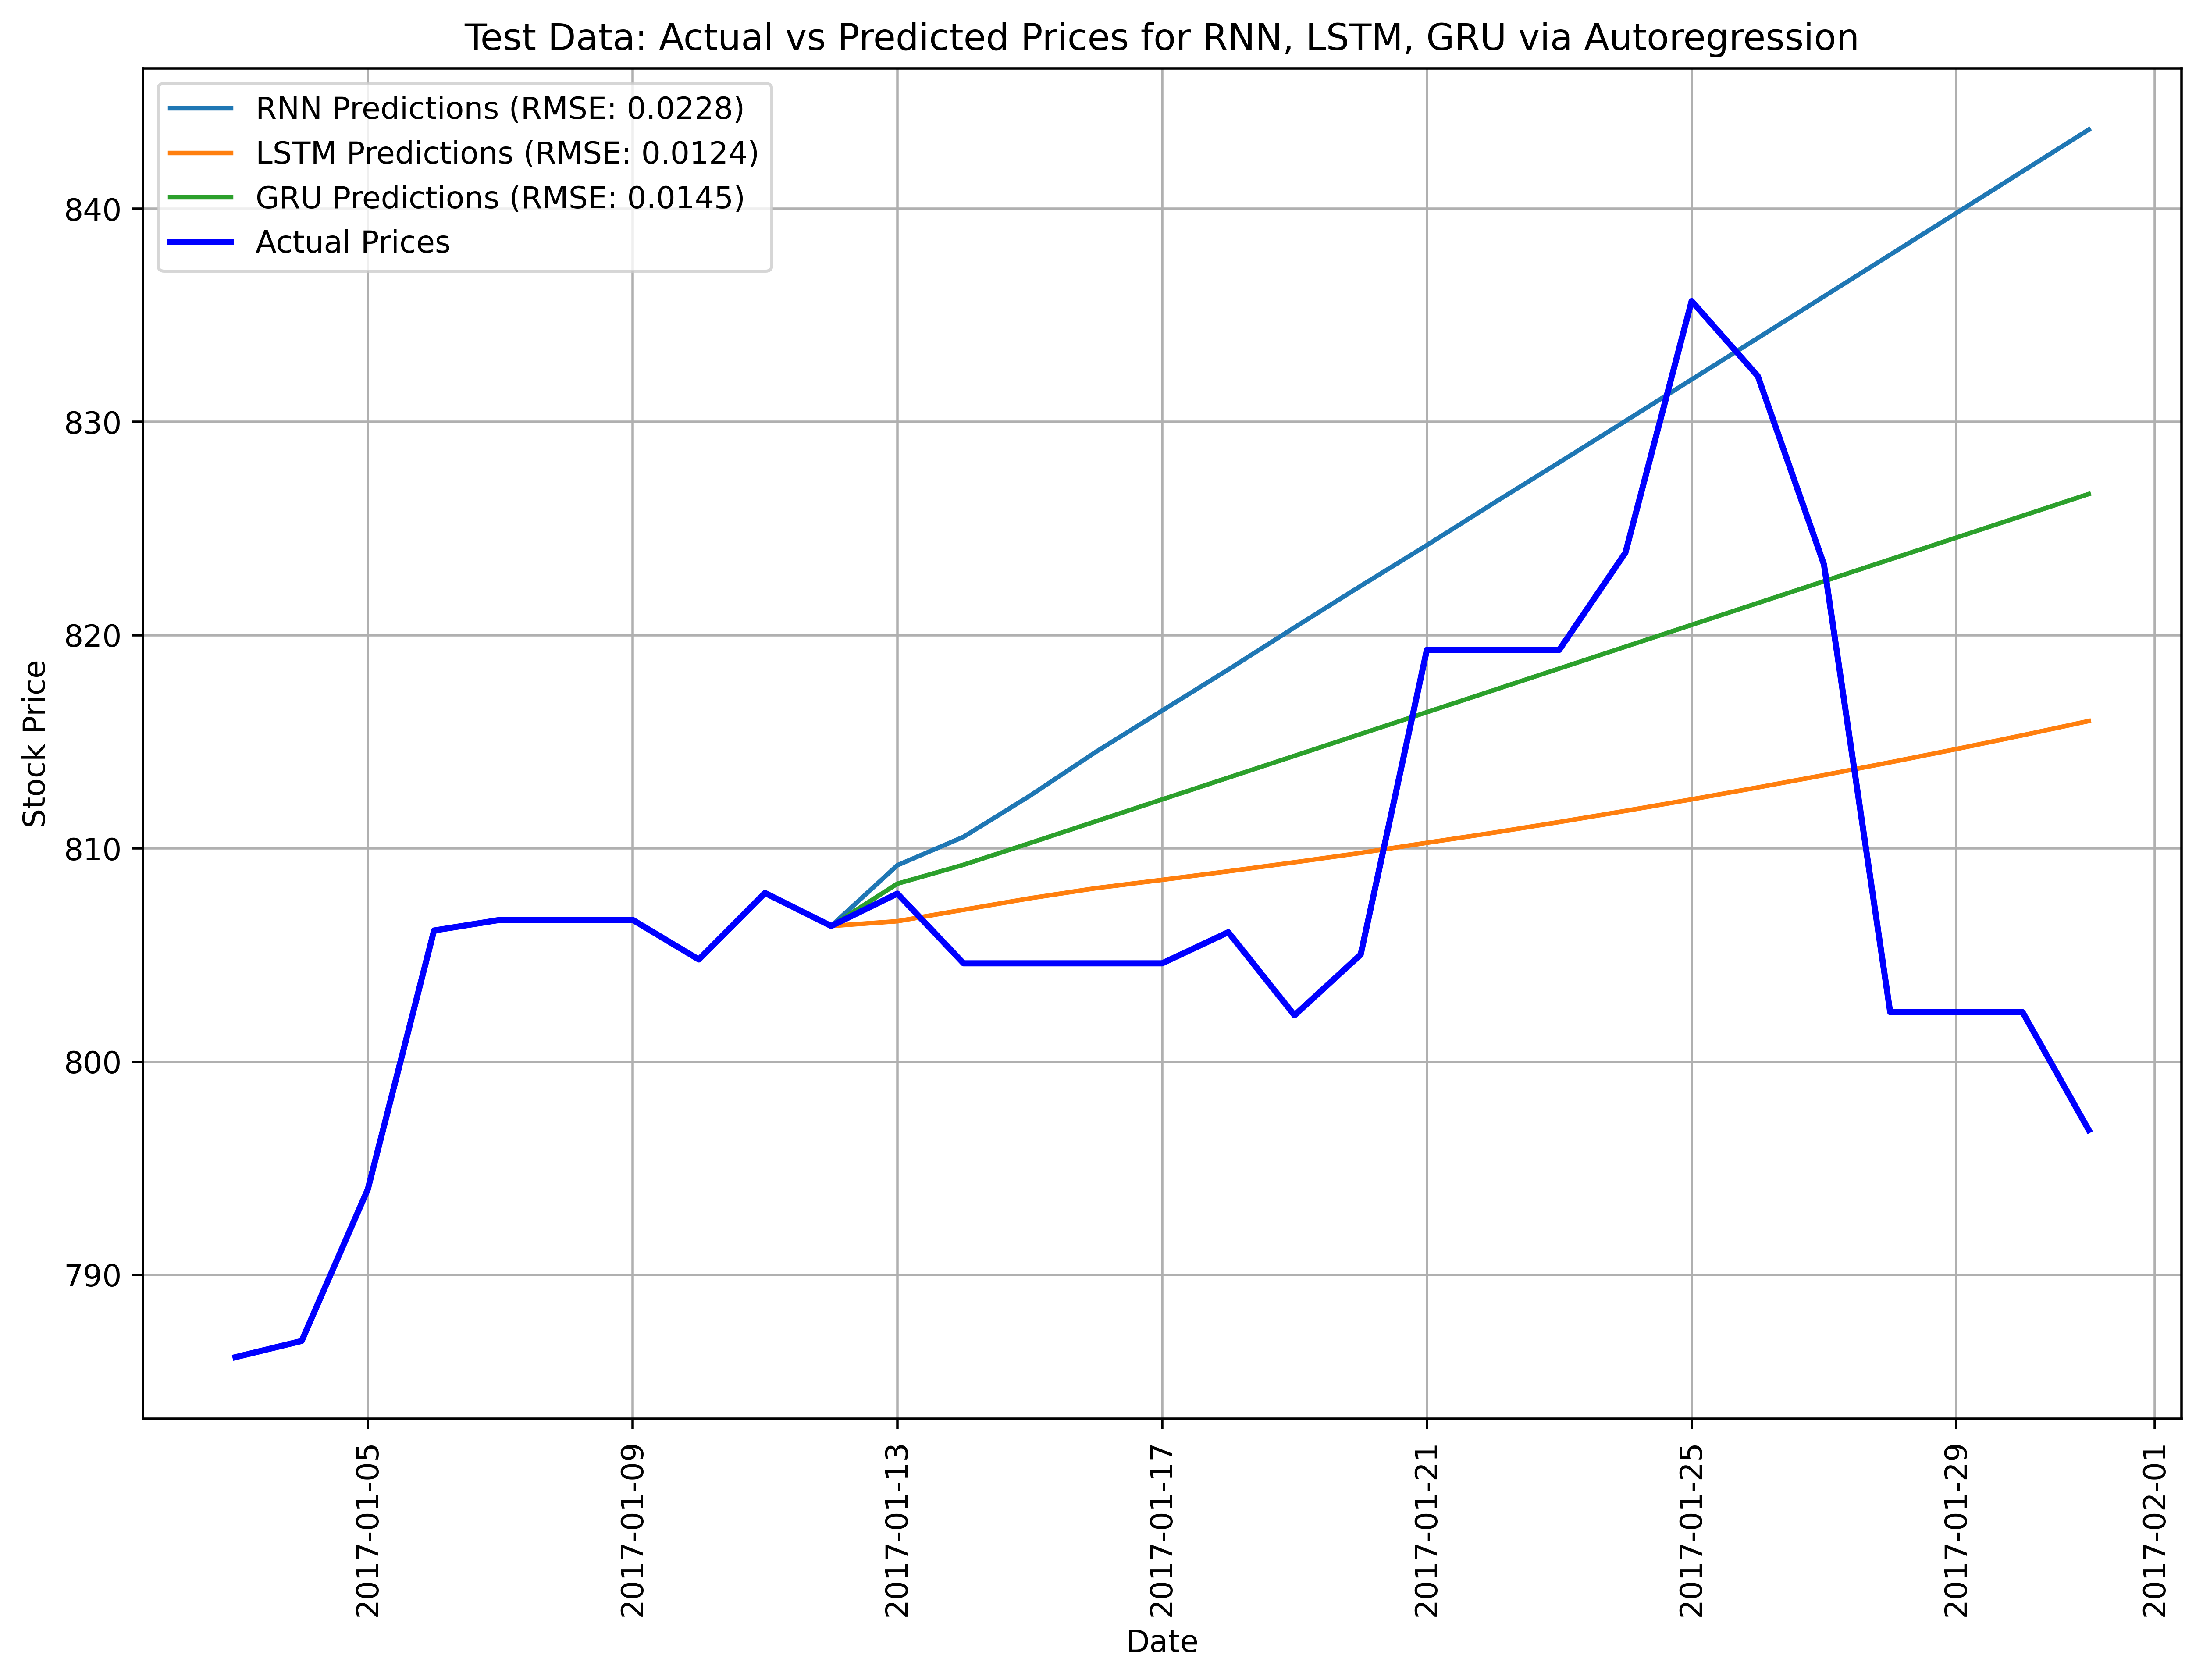

In [35]:
plt.figure(figsize=(12, 8))
actual_prices = scaler_close.inverse_transform(y_test.numpy().reshape(-1, 1))
final_results_auto = []
actual_output = None
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    # Filter the best parameters for this model
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    best_params = {
        'hidden_size': best_row['Hidden_Size'],
        'num_layers': best_row['Num_Layers'],
        'learning_rate': best_row['Learning_Rate']
    }
    best_weights = best_row['Best_Models'][0]  # Load the best model weights for the first fold
    
    # Initialize and load the model
    best_model = model_class(input_size=1, hidden_size=int(best_params['hidden_size']),
                             num_layers=int(best_params['num_layers']), output_size=1)
    best_model.load_state_dict(best_weights)
    
    # Evaluate on the test set
    
    best_model.eval()
    with torch.no_grad():
        # Autoregression
        test_output, actual_output = auto_regression(best_model, X_test, y_test)
        predicted_prices = scaler_close.inverse_transform(test_output.numpy())
        actual_prices = scaler_close.inverse_transform(actual_output.numpy())
    
    # Calculate RMSE for test set
    criterion = nn.MSELoss()
    test_rmse = np.sqrt(criterion(test_output, actual_output).item())
    print(f"Test RMSE for {model_name}: {test_rmse:.4f}")
    
    # Plot the predictions
    plt.plot(df_test['Date'], predicted_prices, label=f'{model_name} Predictions (RMSE: {test_rmse:.4f})')
    final_results_auto.append({
        'Model': model_name,
        'Hidden size': best_row['Hidden_Size'],
        '#Layers': best_row['Num_Layers'],
        'Learning rate': best_row['Learning_Rate'],
        'Avg Val RMSE': best_row['Avg_Val_RMSE'],
        'Autoregressive Test RMSE': test_rmse
    })

# Plot actual prices
plt.plot(df_test['Date'], actual_prices, label='Actual Prices', color='blue', linewidth=2)

# Customize the plot
plt.title('Test Data: Actual vs Predicted Prices for RNN, LSTM, GRU via Autoregression')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


In [32]:
fr_auto = pd.DataFrame(final_results_auto)
fr_auto

Model  Hidden size  #Layers  Learning rate  Avg Val RMSE  \
0   RNN           32        1           0.01      0.021602   
1  LSTM           16        1           0.01      0.029571   
2   GRU           64        1           0.01      0.023685   

   Autoregressive Test RMSE  
0                  0.022750  
1                  0.012371  
2                  0.014520